# Assignement 3

Team members:
- Chenene Mohamed
- Aouad Elias
- Qabel Aymen
- Florez de la Colina Inès

# Installing all Necessary Packages

In [ ]:
%%capture
!pip install datasets
!pip install sentencepiece
!pip install nltk==3.4
!git clone https://github.com/huggingface/transformers.git
!pip install ./transformers/.
!pip install bert_score
!pip install sacrebleu
!pip install mosestokenizer
!pip install nlp
!pip install rouge_score rouge_score

# Importing Packages

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import bert_score
import sacrebleu
import pandas as pd
import numpy as np
from nltk import ngrams
from collections import Counter
import math
from nltk.translate.bleu_score import sentence_bleu
import nlp
from __future__ import division
from itertools import chain
from torchtext.legacy import data
import random
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import seaborn

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


# TASK 1

## Deliverable 1.1: Some examples

- OUTPUT: print some examples from the test/validation split of each task showing the input/model output/ target reference.

### Translation

In [ ]:
def buil_bataset(dataset, split=0.3):
    """Splits the data into training set, validation set and test set of 
    size 70%, 15%, 15% respectively."""
    
    # Build the dataset
    dataset = dataset.train_test_split(test_size=0.3)

    dataset_train, dataset_test_valid = dataset['train'], dataset['test']

    # divide the test into train and test
    dataset_test_valid = dataset_test_valid.train_test_split(test_size=0.5)
    dataset_valid, dataset_test = dataset_test_valid['train'], dataset_test_valid['test']

    return dataset_train, dataset_valid, dataset_test

In [ ]:
def pre_processing(dataset, n):
    """For each input, adds translate English to French to indicate to the T5 model
    to perform translation. Returns the input encodings and decodings as well as the
    batch_input and batch_output.
    n: number of elements we want from the dataset
    dataset: dataset"""

    translations = dataset['translation'][:n]
    batch_input = []
    batch_output = []
    for translation in translations:
        english = "translate English to French: " + translation['en']
        german = translation['fr']
        batch_input.append(english)
        batch_output.append(german)
    input_encodings = tokenizer.prepare_seq2seq_batch(batch_input, padding=True, max_length=512, truncation=True, return_tensors="pt")
    output_encodings = tokenizer.prepare_seq2seq_batch(batch_output, padding=True, max_length=512, truncation=True, return_tensors="pt")

    return input_encodings, output_encodings, batch_input, batch_output

#### Bible_para Dataset

In [ ]:
# Loading the dataset
dataset_bible = load_dataset("bible_para", lang1="en", lang2="fr", split='train')

Using custom data configuration en-fr-lang1=en,lang2=fr


Dataset bible_para downloaded and prepared to /root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1. Subsequent calls will reuse this data.


In [ ]:
# Splitting the data into the training set, the valid set and the test set
dataset_train, dataset_valid, dataset_test = buil_bataset(dataset_bible)

print(f'Dataset train: {dataset_train}')
print(f'Dataset valid: {dataset_valid}')
print(f'Dataset test: {dataset_test}')

Dataset train: Dataset({
    features: ['id', 'translation'],
    num_rows: 43536
})
Dataset valid: Dataset({
    features: ['id', 'translation'],
    num_rows: 9329
})
Dataset test: Dataset({
    features: ['id', 'translation'],
    num_rows: 9330
})


In [ ]:
# Example of a translation from the test set
print('English sentence: ')
print(dataset_test['translation'][0]['en'])
print('French translation: ')
print(dataset_test['translation'][0]['fr'])

English sentence: 
As often as the trumpet sounds he snorts, 'Aha!' He smells the battle afar off, the thunder of the captains, and the shouting.
French translation: 
(39:28) Quand la trompette sonne, il dit: En avant! Et de loin il flaire la bataille, La voix tonnante des chefs et les cris de guerre.


In [ ]:
# Getting the input and output encodings according to the tokenizer of t5-small
tokenizer = T5Tokenizer.from_pretrained('t5-small')
input_encodings, output_encodings, batch_input, batch_output = pre_processing(dataset_test, 10)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


In [ ]:
# Loading the model
model = T5ForConditionalGeneration.from_pretrained('t5-small', return_dict=True)
print('Model loaded!')

# To GPU
model = model.to(device)
input_encodings = input_encodings.to(device)

# Getting the model's outputs
model_output = model.generate(input_encodings["input_ids"], max_length = 512)
print('Outputs generated!')

# Decoding the model's outputs
model_output_decoded = tokenizer.batch_decode(model_output, skip_special_tokens=True)
print('Outputs decoded!')

Model loaded!
Outputs generated!
Outputs decoded!


#### Examples of translation from English to French

In [ ]:
# Printing examples
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print('Translation from English to French')
  print(f'INPUT: {s}')
  print(f'TARGET SENTENCE: {t}')
  print(f'DECODED: {g}')
  print('------------------------------')

Translation from English to French
INPUT: translate English to French: As often as the trumpet sounds he snorts, 'Aha!' He smells the battle afar off, the thunder of the captains, and the shouting.
TARGET SENTENCE: (39:28) Quand la trompette sonne, il dit: En avant! Et de loin il flaire la bataille, La voix tonnante des chefs et les cris de guerre.
DECODED: Souvent que les sons de trompette s'enfoncent, 'Aha!' Il s'enfonce à la bataille à loin, au tonneau des capitaines et au cri.
------------------------------
Translation from English to French
INPUT: translate English to French: It was planted in a good soil by many waters, that it might bring forth branches, and that it might bear fruit, that it might be a goodly vine.
TARGET SENTENCE: Elle était plantée dans un bon terrain, près d`une eau abondante, de manière à produire des branches et à porter du fruit, à devenir une vigne magnifique.
DECODED: Il a été planté dans un bon sol par de nombreuses eaux, qu'il puisse produire des branc

### Summarization

In this part we will use the cnn-dailymail dataset from Hugging Face.

In [ ]:
def pre_processing_summarize(dataset, n):
    """For each input, adds summarize to indicate to the T5 model to perform translation. 
    Returns the input encodings and decodings as well as the batch_input and batch_output.
    n: number of elements we want from the dataset
    dataset: dataset"""

    batch_in = dataset['article'][:n]
    batch_output = dataset['highlights'][:n]
    batch_input = []
    for art in batch_in:
        batch_input.append('summarize: ' + art)
    input_encodings = tokenizer.prepare_seq2seq_batch(batch_input, padding=True, max_length=512, truncation=True, return_tensors="pt")
    output_encodings= tokenizer.prepare_seq2seq_batch(batch_output, padding=True, max_length=512, truncation=True, return_tensors="pt")
    
    return input_encodings, output_encodings, batch_input, batch_output

#### Cnn-dailymail

In [ ]:
# Loading the dataset
dataset_cnn_train = load_dataset("cnn_dailymail", '3.0.0', split='train')
dataset_cnn_valid = load_dataset("cnn_dailymail", '3.0.0', split='validation')
dataset_cnn_test = load_dataset("cnn_dailymail", '3.0.0', split='test')

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0a01b1abede4f646130574f203de57a293ded8a7a11e3406a539453afdfeb2c0. Subsequent calls will reuse this data.


Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0a01b1abede4f646130574f203de57a293ded8a7a11e3406a539453afdfeb2c0)
Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0a01b1abede4f646130574f203de57a293ded8a7a11e3406a539453afdfeb2c0)


In [ ]:
# Getting the encodings
tokenizer = T5Tokenizer.from_pretrained('t5-small')
input_encodings, output_encodings, batch_input, batch_output = pre_processing_summarize(dataset_cnn_test, 10)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


In [ ]:
# Loading the model
model = T5ForConditionalGeneration.from_pretrained('t5-small', return_dict=True)
print('Model loaded!')

# To GPU
model = model.to(device)
input_encodings = input_encodings.to(device)

# Getting the model's outputs
model_output = model.generate(input_encodings["input_ids"], max_length = 512)
print('Outputs generated!')

# Decoding the model's outputs
model_output_decoded = tokenizer.batch_decode(model_output, skip_special_tokens=True)
print('Outputs decoded!')

Model loaded!
Outputs generated!
Outputs decoded!


#### Examples of Summarization

In [ ]:
# Printing examples
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print('Summarize')
  print(f'INPUT: {s}')
  print(f'TARGET summary: {t}')
  print(f'DECODED: {g}')
  print('------------------------------')

Summarize
INPUT: summarize: (CNN)James Best, best known for his portrayal of bumbling sheriff Rosco P. Coltrane on TV's "The Dukes of Hazzard," died Monday after a brief illness. He was 88. Best died in hospice in Hickory, North Carolina, of complications from pneumonia, said Steve Latshaw, a longtime friend and Hollywood colleague. Although he'd been a busy actor for decades in theater and in Hollywood, Best didn't become famous until 1979, when "The Dukes of Hazzard's" cornpone charms began beaming into millions of American homes almost every Friday night. For seven seasons, Best's Rosco P. Coltrane chased the moonshine-running Duke boys back and forth across the back roads of fictitious Hazzard County, Georgia, although his "hot pursuit" usually ended with him crashing his patrol car. Although Rosco was slow-witted and corrupt, Best gave him a childlike enthusiasm that got laughs and made him endearing. His character became known for his distinctive "kew-kew-kew" chuckle and for goo

### Question Answering

In this part we will use the BoolQ dataset from Hugging Face.

In [ ]:
def build_bataset_bool(dataset, split=0.5):
    # Build the dataset

    dataset_train = load_dataset(dataset, split='train')
    dataset_valid_test = load_dataset(dataset, split='validation')

    # divide the validation into train and test
    dataset_valid_test = dataset_valid_test.train_test_split(test_size=0.5)
    dataset_valid, dataset_test = dataset_valid_test['train'], dataset_valid_test['test']

    return dataset_train, dataset_valid, dataset_test

In [ ]:
def convert_bool_to_string(answer):
    answer_str = []
    for bl in answer:
        if bl:
            answer_str.append('True')
        else:
            answer_str.append('False')
    return answer_str

In [ ]:
def pre_processing_qa(dataset, n):
    answer = convert_bool_to_string(dataset['answer'][:n])
    ques = dataset['question'][:n]
    cont = dataset['passage'][:n]
    question = []
    context = []
    qandc = []

    for q, c in zip(ques, cont):
        question.append('question: ' + q)
        context.append('context: ' + c)
        qandc.append("question: %s  context: %s </s>" % (q, c))

    input_encodings = tokenizer.prepare_seq2seq_batch(qandc, padding=True, max_length=512, truncation=True, return_tensors="pt")
    output_encodings= tokenizer.prepare_seq2seq_batch(answer, padding=True, max_length=512, truncation=True, return_tensors="pt")
    
    return input_encodings, output_encodings, qandc, answer

#### BoolQ Dataset

In [ ]:
# Loading the dataset
dataset_bool_train, dataset_bool_valid, dataset_bool_test = build_bataset_bool("boolq")

Using custom data configuration default


Dataset boolq downloaded and prepared to /root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534. Subsequent calls will reuse this data.


Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)


In [ ]:
print(f'Train Dataset: {dataset_bool_train}')
print(f'Valid Dataset: {dataset_bool_valid}')
print(f'Test Dataset: {dataset_bool_test}')

Train Dataset: Dataset({
    features: ['question', 'answer', 'passage'],
    num_rows: 9427
})
Valid Dataset: Dataset({
    features: ['question', 'answer', 'passage'],
    num_rows: 1635
})
Test Dataset: Dataset({
    features: ['question', 'answer', 'passage'],
    num_rows: 1635
})


In [ ]:
# Example of data from the test set
print(f'Question: {dataset_bool_test["question"][0]}')
print(f'Answer: {dataset_bool_test["answer"][0]}')
print(f'Passage: {dataset_bool_test["passage"][0]}')

Question: is film stars don't die in liverpool a true story
Answer: True
Passage: Film Stars Don't Die in Liverpool is a 2017 biographical romantic drama film directed by Paul McGuigan and starring Annette Bening and Jamie Bell. Vanessa Redgrave, Julie Walters, Kenneth Cranham, Stephen Graham, Frances Barber and Leanne Best also star. It is based on the memoir of the same name by Peter Turner, which tells of his relationship with aging Hollywood actress Gloria Grahame in 1970s Liverpool and, some years later, her death from breast cancer.


In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
input_encodings, output_encodings, batch_input, batch_output = pre_processing_qa(dataset_bool_test, 10)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:175: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


In [ ]:
# Loading the model
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-small-finetuned-boolq")
print('Model loaded!')

# To GPU
model = model.to(device)
input_encodings = input_encodings.to(device)

# Getting the model's outputs
model_output = model.generate(input_encodings["input_ids"], max_length = 512)
print('Outputs generated!')

# Decoding the model's outputs
model_output_decoded = tokenizer.batch_decode(model_output, skip_special_tokens=True)
print('Outputs decoded!')

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.



Model loaded!
Outputs generated!
Outputs decoded!


In [ ]:
# Printing examples
dic = {'yes': True, 'no': False}
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print('Q&A')
  print(f'INPUT: {s}')
  print(f'TARGET ANSWER: {t}')
  print(f'DECODED: {dic[g]}')
  print('------------------------------')

Q&A
INPUT: question: is film stars don't die in liverpool a true story  context: Film Stars Don't Die in Liverpool is a 2017 biographical romantic drama film directed by Paul McGuigan and starring Annette Bening and Jamie Bell. Vanessa Redgrave, Julie Walters, Kenneth Cranham, Stephen Graham, Frances Barber and Leanne Best also star. It is based on the memoir of the same name by Peter Turner, which tells of his relationship with aging Hollywood actress Gloria Grahame in 1970s Liverpool and, some years later, her death from breast cancer. </s>
TARGET ANSWER: True
DECODED: False
------------------------------
Q&A
INPUT: question: does the prime minister live at number 10 downing street  context: 10 Downing Street, colloquially known in the United Kingdom as Number 10, is the headquarters of the Government of the United Kingdom and the official residence and office of the First Lord of the Treasury, a post which, for much of the 18th and 19th centuries and invariably since 1905, has been 

## Deliverable 1.2: Implement extra evaluation metrics

- implement evaluation metrics : BLEU, ROUGE
- Select ~1000 sentences from each of the datasets (use test when available, or - validation split otherwise)
- Table1: Evaluate your model on those Metrics
- Table2: As a sanity check of your implementation use already existing implementation online of those metrics and compare them together with your implementation.

### Implementing Blue score for machine translation

In [ ]:
# Compute the average bleu score of our dataset over 1000 translations
tokenizer = T5Tokenizer.from_pretrained('t5-small')
input_encodings, output_encodings, batch_input, batch_output = pre_processing(dataset_test, 1000)
print("Computed encodings")

# To GPU
model = model.to(device)
input_encodings = input_encodings.to(device)

model_output = model.generate(input_encodings["input_ids"], max_length = 512)
print('Outputs generated!')

# Decoding the model's outputs
model_output_decoded = tokenizer.batch_decode(model_output, skip_special_tokens=True)
print('Outputs decoded!')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Computed encodings
Outputs generated!
Outputs decoded!


Main steps for implementing the Blue score:
- Counting word vectors
- Count clip
- Compute modified precision
- Brevity penalty
- Compute final blue score

In [ ]:
def n_gram_generator(sentence, n= 2,n_gram= False):
    """Generates n-grams with n the number of n-grams and the n-gram parameter removes repeating
    n-grams if set to true"""

    sentence = sentence.lower() # converting to lower case
    sent_arr = np.array(sentence.split()) # split to string arrays
    length = len(sent_arr)

    word_list = []
    for i in range(length+1):
        if i < n:
            continue
        word_range = list(range(i-n,i))
        s_list = sent_arr[word_range]
        string = ' '.join(s_list) # converting list to strings
        word_list.append(string) # append to word_list
        if n_gram:
            word_list = list(set(word_list))
    return word_list

def bleu_score(original,machine_translated):
    """Computes the Bleu score function given the original and a machine translated sentences"""

    mt_length = len(machine_translated.split())
    o_length = len(original.split())

    # Brevity Penalty 
    if mt_length>o_length:
        BP=1
    else:
        penality=1-(mt_length/o_length)
        BP=np.exp(penality)

    # Clipped precision
    clipped_precision_score = []
    for i in range(1, 5):
        original_n_gram = Counter(n_gram_generator(original,i))
        machine_n_gram = Counter(n_gram_generator(machine_translated,i))

        c = sum(machine_n_gram.values())
        for j in machine_n_gram:
            if j in original_n_gram:
                if machine_n_gram[j] > original_n_gram[j]:
                    machine_n_gram[j] = original_n_gram[j]
            else:
                machine_n_gram[j] = 0

        if c == 0:
            return 0
        clipped_precision_score.append(sum(machine_n_gram.values())/c)

    weights =[0.5]*2 #usually weights=(0.25, 0.25, 0.25, 0.25). See comment below to understand this choice of weights

    for w_i, p_i in zip(weights, clipped_precision_score):
        if p_i == 0:
            return 0

    s = (w_i * math.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score) if p_i!=0)
    s = BP * math.exp(math.fsum(s))
    return s

In [ ]:
print(batch_output[2])
print(model_output_decoded[2])
print(f'Bleu score, implementation from scratch: {bleu_score(batch_output[2], model_output_decoded[2])}')
print(f'Bleu score NLTK: {sentence_bleu([batch_output[2].split()], model_output_decoded[2].split(), weights=(0.5, 0.5))}')
print('The implementation works!')

Et sur la moitié qui revient aux enfants d`Israël tu prendras un sur cinquante, tant des personnes que des boeufs, des ânes et des brebis, de tout animal; et tu le donneras aux Lévites, qui ont la garde du tabernacle de l`Éternel.
De la moitié des enfants israéliens, vous prenez un tiré sur cinquante, des personnes, des bovins, des crotales et des troupeaux, de tous les bétails, et les donnez aux Léttes, qui s'acquittent du devoir du tabernacle de Yahweh.
Bleu score, implementation from scratch: 0.27828511264736966
Bleu score NLTK: 0.22772640266196353
The implementation works!


In [ ]:
def comparing_bleu_scores(model_output_decoded, batch_output):
    """Compare the bleu scores obtained with our bleu score implementation
    and NLTK's implementation"""
    total_bleu = 0
    total_bleu_nltk = 0
    for i in range(len(batch_output)):
        if model_output_decoded[i] != '':
            total_bleu += bleu_score(batch_output[i], model_output_decoded[i])
            total_bleu_nltk += sentence_bleu([batch_output[i].split()], model_output_decoded[i].split(), weights=(0.5, 0.5))
    return total_bleu/len(batch_output), total_bleu_nltk/len(batch_output)

In [ ]:
bleu_score_scratch, bleu_score_nltk = comparing_bleu_scores(model_output_decoded, batch_output)
print(f'Bleu score: {bleu_score_scratch}')
print(f'Bleu score NLTK: {bleu_score_nltk}')

0.09163456910240271
0.30219329100548165
0.5299196936674452
1.0409758790382868
1.2011350541120915
1.2011350541120915
1.3740932279996818
1.5822081959861518
1.7990227411821489
1.9911765257482534
Bleu score: 0.2754321329469614
Bleu score NLTK: 0.19911765257482533


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


The difference between both scores is mainly due to the warnings obtained for the bleu score for the NLTK implementation. These warnings state the abscence of some n-grams. To reduce as much as possible these errors, we have set the wiegths to weights=(0.5, 0.5), even though the usual implementation takes weights=(0.25, 0.25, 0.25, 0.25).

### Implementing the ROUGE score for summarization

In [ ]:
# Compute the average rouge score of our dataset over 100 summarizations to avoid running out of CUDA memory
tokenizer = T5Tokenizer.from_pretrained('t5-small')
input_encodings, output_encodings, batch_input, batch_output = pre_processing_summarize(dataset_cnn_test, 100)
print("Computed encodings")

# To GPU
model = T5ForConditionalGeneration.from_pretrained('t5-small', return_dict=True)
model = model.to(device)
input_encodings = input_encodings.to(device)

model_output = model.generate(input_encodings["input_ids"], max_length = 512)
print('Outputs generated!')

# Decoding the model's outputs
model_output_decoded = tokenizer.batch_decode(model_output, skip_special_tokens=True)
print('Outputs decoded!')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Computed encodings



Outputs generated!
Outputs decoded!


#### Implementation from scratch of the rouge score

##### Rouge-N score

Below you can find an implementation of the rouge-N score. To do so we focus on the formula given by \url{https://www.aclweb.org/anthology/W04-1013.pdf}. Hence the amin steps of the computation are:
- Compute the n-grams for the original and decoded summaries
- Count the occurences of each n-gram
- Find the matches between the common n-grams present in the original and decoded summaries
- Compute the F1 score


In [ ]:
from __future__ import division
import collections

def _ngrams(sentence, n , n_gram= False):
    """Generates n-grams with n the number of n-grams and the n-gram parameter removes repeating
    n-grams if set to true"""

    sentence = sentence.lower() # converting to lower case
    sent_arr = np.array(sentence.split()) # split to string arrays
    length = len(sent_arr)

    word_list = []
    for i in range(length+1):
        if i < n:
            continue
        word_range = list(range(i-n,i))
        s_list = sent_arr[word_range]
        string = ' '.join(s_list) # converting list to strings
        word_list.append(string) # append to word_list
        if n_gram:
            word_list = list(set(word_list))
    return word_list

def _ngram_counts(words, n):
    return collections.Counter(_ngrams(words, n))

def _ngram_count(sentence, n):
    return max(len(sentence.split()) - n + 1, 0)

def matches(ngram1, ngram2):
    matches = 0
    for key, value in ngram1.items():
        if key in ngram2.keys():
            matches += min(value, ngram2[key])
    return matches

def do_division(numerator, denominator):
    if denominator > 0:
        return numerator / denominator
    else:
        return 0

def f1_score(matches, recall_total, precision_total):

    recall_score = do_division(matches, recall_total)
    precision_score = do_division(matches, precision_total)
    denom = precision_score + recall_score
    if denom > 0.0:
        return (2 * precision_score * recall_score) / denom
    else:
        return 0.0

def rouge_n(peer, model, n):
    """
    Compute the ROUGE-N score of a peer with respect to one or more models, for
    a given value of `n`.
    """
    match = 0
    recall_total = 0

    peer_counter = dict(_ngram_counts(peer, n))
    model_counter = dict(_ngram_counts(model, n))

    match = matches(peer_counter, model_counter)

    recall_total = _ngram_count(model, n)
    precision_total = _ngram_count(peer, n)

    return f1_score(match, recall_total, precision_total)

In [ ]:
def apply_rouge_n(model_output_decoded, batch_output):
    rouge1 = 0
    rouge2 = 0
    for mod_out, bat_out in zip(model_output_decoded, batch_output):
        rouge1 += rouge_n(mod_out, bat_out, 1)
        rouge2 += rouge_n(mod_out, bat_out, 2)
    return rouge1/len(batch_output), rouge2/len(batch_output)

In [ ]:
rouge1, rouge2 = apply_rouge_n(model_output_decoded, batch_output)
print('rouge1: {:.4f}, rouge2: {:.4f}'.format(rouge1, rouge2))

rouge1: 0.2282, rouge2: 0.0681


##### Rouge-L score

In [ ]:
def lcs(X, Y):
    """Dynamic programming approach"""

    x = X.split()
    y = Y.split()

    m = len(x)
    n = len(y)

    L = [[None]*(n + 1) for i in range(m + 1)]

    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0 :
                L[i][j] = 0
            elif x[i-1] == y[j-1]:
                L[i][j] = L[i-1][j-1]+1
            else:
                L[i][j] = max(L[i-1][j], L[i][j-1])

    return L[m][n], m, n

In [ ]:
def rouge_l_score(X, Y, beta=1):

    LCS, m, n = lcs(X, Y)

    recall = LCS/m
    precision = LCS/n

    fscore = ((1+beta**2) * recall * precision)/(recall + beta**2 * precision)

    return fscore

In [ ]:
def apply_rouge_l(model_output_decoded, batch_output):
    rouge_l = 0
    for mod_out, bat_out in zip(model_output_decoded, batch_output):
        rouge_l += rouge_l_score(bat_out, mod_out)
    return rouge_l/len(batch_output)

In [ ]:
r_l = apply_rouge_l(model_output_decoded, batch_output)
print(f'RougeL: {r_l}')

RougeL: 0.15414846172609964


#### Implementation using nlp's rouge metric

In [ ]:
def get_mean_elements(score):
    r1, r2, rL = 0, 0, 0 
    for k, s in score.items():
        if k == "rouge1":
            r1 = sum([s[i].fmeasure for i in range(len(s))])/len(s)
        elif k == "rouge2":
            r2 = sum([s[i].fmeasure for i in range(len(s))])/len(s)
        else:
            rL = sum([s[i].fmeasure for i in range(len(s))])/len(s)
    return r1, r2, rL

def run_rouge(model_output_decoded, batch_output):
    rouge = nlp.load_metric('rouge')
    for lp, lg in zip(model_output_decoded, batch_output):
        rouge.add(lp, lg)
    score = rouge.compute(rouge_types=["rouge1", "rouge2", "rougeL"], use_agregator=False)
    return get_mean_elements(score)

In [ ]:
rouge1, rouge2, rougeL = run_rouge(model_output_decoded, batch_output)
print('rouge1: {:.4f}, rouge2: {:.4f}, rougeL: {:.4f}'.format(rouge1, rouge2, rougeL))

rouge1: 0.2654, rouge2: 0.0888, rougeL: 0.1959


#### Implementation using rouge_score's rouge metric

In [ ]:
from rouge_score import rouge_scorer

def run_rouge_bis(model_output_decoded, batch_output):
    r1, r2, rL = 0, 0, 0 
    n = len(batch_output)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    for lp, lg in zip(model_output_decoded, batch_output):
        sc = scorer.score(lp, lg)
        r1 += sc['rouge1'].fmeasure
        r2 += sc['rouge2'].fmeasure
        rL += sc['rougeL'].fmeasure
    return r1/n, r2/n, rL/n

In [ ]:
rouge1, rouge2, rougeL = run_rouge_bis(model_output_decoded, batch_output)
print('rouge1: {:.4f}, rouge2: {:.4f}, rougeL: {:.4f}'.format(rouge1, rouge2, rougeL))

rouge1: 0.2805, rouge2: 0.0925, rougeL: 0.2050


By comparing the results we obtained with the ones obtained using the two open source implementations, we can see that, on average, we get lower results. Nevertheless, all results are quite similar. the values even vary from one open source implementation to the other.

## Deliverable 1.3: Implement Decoding methods of your own

- Table1: Check Correctness of your implementation, in a table show a comparison between results obtained from model.generate function and your implementation for different beam-sizes for beamsearch and top-p

- Table2: Compare between different decoding methods. for summarization and machine translation and question answering try different decoding methods for example try changing the top-p value in the nucleus sampling algorithm the temperature of the softmax and with the beamsize in the beam search (for this only you are allowed to use model.generate and existing implementation of evaluation metrics

- Short Report 300 words max: Given the results you obtained above. Write a short report containing your conclusions on which are the best decoding algorithm / parameter for each task. Why do you think they are the best? Does increasing the beam size usually give better scores? Why or Why not?

### Beam Search

In [ ]:
def beam_search_decoder(model, inputs ,max_length=50, num_beams=3):
  inputs = inputs['input_ids']
  final_result=[]
  for input_ids in inputs:
    sequences = [(1,[0])]

    for _ in range(max_length):
      encoder_input_ids = input_ids.repeat(len(sequences), 1)
      decoder_input_ids = torch.tensor([ids for _, ids in sequences]).to(device)

      outputs = model(encoder_input_ids, decoder_input_ids=decoder_input_ids)
      next_token_logits = outputs.logits[:,-1,:]
      probabilities = torch.softmax(next_token_logits, dim=1)
      top = probabilities.topk(num_beams, dim=1)

      candidate_sequences = []
      for i, (score, ids) in enumerate(sequences):
        for k in range(num_beams):
          candidate_sequences.append((score*top.values[i,k].item(), ids + [top.indices[i,k].item()]))
      sequences = sorted(candidate_sequences,reverse = True)[:num_beams]
    
    final_result.append([tokenizer.decode(torch.tensor(ids).to(device), skip_special_tokes=True) for _, ids in sequences][0])
  return final_result

### Nucleous Sampling:

In [ ]:
def nucleous_decoder(model, input_encodings, p=0.92):
  inputs = input_encodings["input_ids"]
  final_result = []
  for input in inputs:
    input= input.reshape((1,len(input)))  
    sequences = [SOS_token]
    
    for j in range(MAX_LENGTH):
        decoder_init = torch.tensor([sequences], device=device)
        out = model(decoder_input_ids=decoder_init, input_ids = input)
        sorted_output, indices_output = torch.sort(out[0][0,-1,:], descending=True)

        sorted_normalised = torch.softmax(sorted_output, dim=0)
        cumsum_probs = torch.cumsum(sorted_normalised, 0)
        indices_inf_to_p = (cumsum_probs < p).nonzero()
        indices_selected = 1 if len(indices_inf_to_p)==0 else indices_inf_to_p[-1][0].item() + 2
        ind_sampled = torch.multinomial(sorted_normalised[:indices_selected], 1)

        sequences.append(indices_output[ind_sampled].item())

    final_result.append(tokenizer.decode(torch.tensor(sequences).to(device), skip_special_tokes=True))
  return final_result

### Softmax with Temperature:

In [ ]:
def temperature_decoder(model,input_encodings,  T=0.5):
  inputs = input_encodings["input_ids"]
  final_result = []
  for input in inputs:
    input= input.reshape((1,len(input)))  
    sequences = [SOS_token]
    for j in range(MAX_LENGTH):
        decoder_init =torch.tensor([sequences], device=device)
        out = model(decoder_input_ids=decoder_init, input_ids = input)
        sorted_output, indices_output = torch.sort(out[0][0,-1,:], descending=True)

        sorted_normalised = torch.softmax(sorted_output/T, dim=0)
        ind_sampled = torch.multinomial(sorted_normalised, 1)

        sequences.append(indices_output[ind_sampled].item())

    final_result.append(tokenizer.decode(torch.tensor(sequences).to(device), skip_special_tokes=True))
  return final_result

### Checking the correctness of the algorithms:

In [ ]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 100

# Loading the model
model = T5ForConditionalGeneration.from_pretrained('t5-small', return_dict=True)
print('Model loaded!')

# To GPU
model = model.to(device)

tokenizer = T5Tokenizer.from_pretrained('t5-small')
input_encodings, output_encodings, batch_input, batch_output = pre_processing(dataset_test, 10)
input_encodings, output_encodings = input_encodings.to(device), output_encodings.to(device)

In [ ]:
print(batch_output[2])
model_output = model.generate(input_encodings["input_ids"], max_length = 512, num_beams=k)
model_output_decoded_gen = tokenizer.batch_decode(model_output, skip_special_tokens=True)
model_output_decoded_beam = beam_search_decoder(model, input_encodings, num_beams = 5)
model_output_decoded_our = nucleous_decoder(model, input_encodings, p = 0.8)
model_output_decoded_our = temperature_decoder(model, input_encodings, T = 0.43)


print(f'Translation by the model built in function: {model_output_decoded_gen[2]}')
print(f'Translation by our Beam Search: {model_output_decoded_gen[2]}')
print(f'Translation by our Nucleous sampling: {model_output_decoded_gen[2]}')
print(f'Translation by our Softmax with temperature: {model_output_decoded_gen[2]}')

print('The implementation works!')

Et sur la moitié qui revient aux enfants d`Israël tu prendras un sur cinquante, tant des personnes que des boeufs, des ânes et des brebis, de tout animal; et tu le donneras aux Lévites, qui ont la garde du tabernacle de l`Éternel.
Translation by the model built in function: De la moitié des enfants israéliens, vous emportez un tiré sur cinquante, des personnes, des bovins, des crotales et des troupeaux, de tous les bétails, et les cédez aux Léttes, qui s'acquittent du devoir du tabernacle de Yahweh.
Translation by our Beam Search: De la moitié des enfants israéliens, vous emportez un tiré sur cinquante, des personnes, des bovins, des crotales et des troupeaux, de tous les bétails, et les cédez aux Léttes, qui s'acquittent du devoir du tabernacle de Yahweh.
Translation by our Nucleous sampling: De la moitié des enfants israéliens, vous emportez un tiré sur cinquante, des personnes, des bovins, des crotales et des troupeaux, de tous les bétails, et les cédez aux Léttes, qui s'acquittent 

### Comparison:

#### Effect of beam size:

In [ ]:
def bleu_scores(model_output_decoded, batch_output):
    total_bleu_nltk = 0
    for i in range(len(batch_output)):
        if model_output_decoded[i] != '':
            total_bleu_nltk += sentence_bleu([batch_output[i].split()], model_output_decoded[i].split(), weights=(0.5, 0.5))
    return total_bleu_nltk/len(batch_output)

In [ ]:
score_blue = []
score_blue_gen = []
for k in range(1,15):
  model_output_decoded_our = beam_search_decoder(model, input_encodings, num_beams = k)
  model_output = model.generate(input_encodings["input_ids"], max_length = 512, num_beams=k)
  model_output_decoded_gen = tokenizer.batch_decode(model_output, skip_special_tokens=True)
  score_blue.append(bleu_scores(model_output_decoded_our, batch_output))
  score_blue_gen.append(bleu_scores(model_output_decoded_gen, batch_output))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


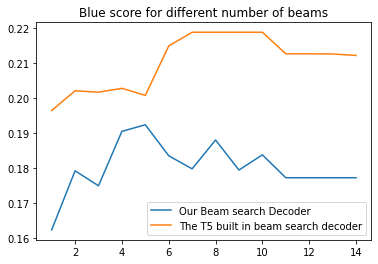

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1,15),score_blue, label='Our Beam search Decoder')
plt.plot(range(1,15),score_blue_gen, label='The T5 built in beam search decoder')
plt.title('Blue score for different number of beams')
plt.legend()
plt.show()

#### Effect of p value in the Top-p decoder:

In [ ]:
score_blue = []
score_blue_gen = []
list_range =  np.linspace(0.3,1,15)
for k in list_range:
  model_output_decoded_our = nucleous_decoder(model, input_encodings, p = k)
  model_output = model.generate(input_encodings["input_ids"], max_length = 512)
  model_output_decoded_gen = tokenizer.batch_decode(model_output, skip_special_tokens=True)
  score_blue.append(bleu_scores(model_output_decoded_our, batch_output))
  score_blue_gen.append(bleu_scores(model_output_decoded_gen, batch_output))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


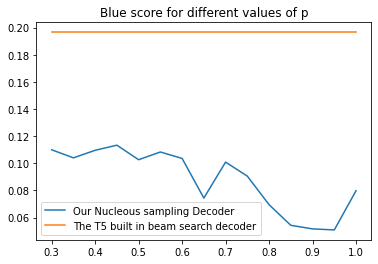

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list_range,score_blue, label='Our Nucleous sampling Decoder')
plt.plot(list_range,score_blue_gen, label='The T5 built in beam search decoder')
plt.title('Blue score for different values of p')
plt.legend()
plt.show()

#### Effect of Temperature:

In [ ]:
score_blue = []
score_blue_gen = []
list_range =  np.linspace(0.1,1,15)
for k in list_range:
  model_output_decoded_our = temperature_decoder(model, input_encodings, T = k)
  model_output = model.generate(input_encodings["input_ids"], max_length = 512)
  model_output_decoded_gen = tokenizer.batch_decode(model_output, skip_special_tokens=True)
  score_blue.append(bleu_scores(model_output_decoded_our, batch_output))
  score_blue_gen.append(bleu_scores(model_output_decoded_gen, batch_output))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


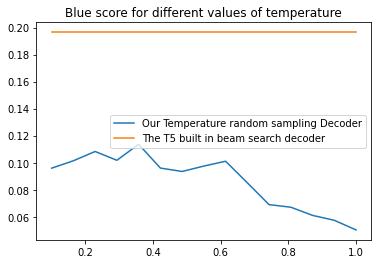

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list_range,score_blue, label='Our Temperature random sampling Decoder')
plt.plot(list_range,score_blue_gen, label='The T5 built in beam search decoder')
plt.title('Blue score for different values of temperature')
plt.legend()
plt.show()

### Short Report about the differences between the different decoding algorithms:

After implementing these different decoding methods successfully, we tried to change their parameters to see their effects.
First of all, we have seen that the three algorithms gave great results that are similar to model.generate function. 
And to compare them in more details, we decided to compare the blue scores in the translation Task.

For the beam search method, we can see that the score increases with the beamsize, and then decreases at the end, which is logic, because that's the point of using beam Search instead of greedy search (beamsize = 1). And when the beamsize becomes very big, the algorithm can start generating easy sequences that are more probable for all inputs.

For the nucleous sampling method, we have seen increasing the value of p have a good effect in the begining and then start doing the opposite when we're close to 1. In fact, if we set p to 1, it's similar to use greedy random sampling, which can give some random words that don't fit. It has a very good idea that when the model is very certain on some tokens, the set of potential candidate tokens is small otherwise, there will be more potential candidate tokens.

For the Random Sampling with Temperature, we can see that the best temperature in the example above was 0.43, and the model decreases when it's close to 1, which is again very logic, because with T = 1, we have the greedy sampling approach. The idea behind this method is very interesting, since it is used to increase the probability of probable tokens while reducing the one that is not.

Going through all these different ways to decode the model outputs, we have seen that they all give satisfying results, for the different generation tasks (translation, summurization, Question Answering). Also, we have seen that the decoding method is very important to have good results. In fact, using a good model with bad decoding strategies or a bad model with good decoding strategies is not enough. A good balance between the two can make the generation a lot more interesting.


# Task 2

## Deliverable 2.1 : Implement cross-attention matrix vizualization

### cross-attention matrices for Translation

In [ ]:
# Loading the dataset
dataset_bible = load_dataset("bible_para", lang1="en", lang2="fr", split='train')

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


In [ ]:
# Splitting the data into the training set, the valid set and the test set
dataset_train, dataset_valid, dataset_test = buil_bataset(dataset_bible)

Loading cached split indices for dataset at /root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1/cache-d577c107c18c600c.arrow and /root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1/cache-6e180ce0d0142246.arrow
Loading cached split indices for dataset at /root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1/cache-d51bf86392a9c41c.arrow and /root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1/cache-ddd3509bb51a33b4.arrow


In [ ]:
# Loading the model
model = T5ForConditionalGeneration.from_pretrained('t5-small', return_dict=True)
print('Model loaded!')

Model loaded!


In [ ]:
# Getting the input and output encodings according to the tokenizer of t5-small
tokenizer = T5Tokenizer.from_pretrained('t5-small')
input_encodings, output_encodings, batch_input, batch_output = pre_processing(dataset_test, 1)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


In [ ]:
def get_sent_from_ids(input_encodings, index=0):
    sent = []
    for int_id in input_encodings['input_ids'][index].squeeze().tolist():
        sent += [tokenizer.decode(int_id)]
    return sent

In [ ]:
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)

In [ ]:
# outs = model(input_ids=input_encodings['input_ids'], decoder_input_ids=output_encodings['input_ids'], output_attentions=True)
outs = model(input_ids=input_encodings['input_ids'], labels=output_encodings['input_ids'], output_attentions=True)
sent = get_sent_from_ids(input_encodings)
tgt_sent = get_sent_from_ids(output_encodings)

In [ ]:
print('English sentence')
print(' '.join(sent))
print('French sentence')
print(' '.join(tgt_sent))

English sentence
translate English to French :  Moreover , when you shall divide by lot the land for inheritance , you shall offer an offering to Ya h we h ,  a holy portion of the land ; the length shall be the length of twenty - five thousand [ re e d s ], and the bread th shall be  ten thousand : it shall be holy in all its border all around . </s>
French sentence
Lorsqu e vous partager ez le pays  en  hér it age par le sort , vous pr élève rez comme une saint e of fran de pour  l <unk> É tern e l une portion du pays , longue de vingt - c in q mill e can nes  e t large de dix mill e ;  elle sera saint e dans toute son  étendue . </s>


Cross-Layer number : 1


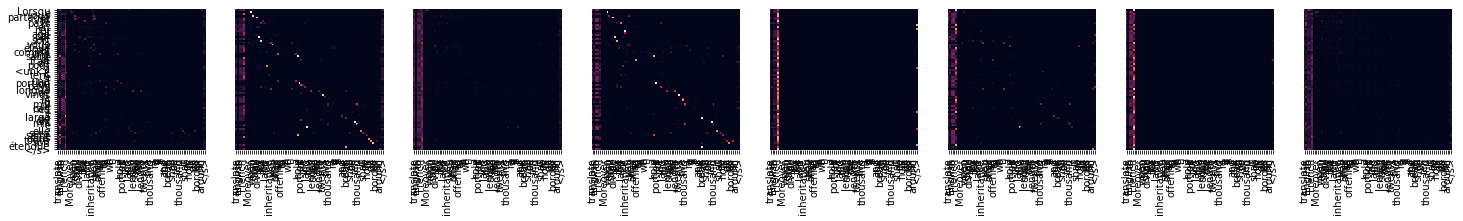

Cross-Layer number : 2


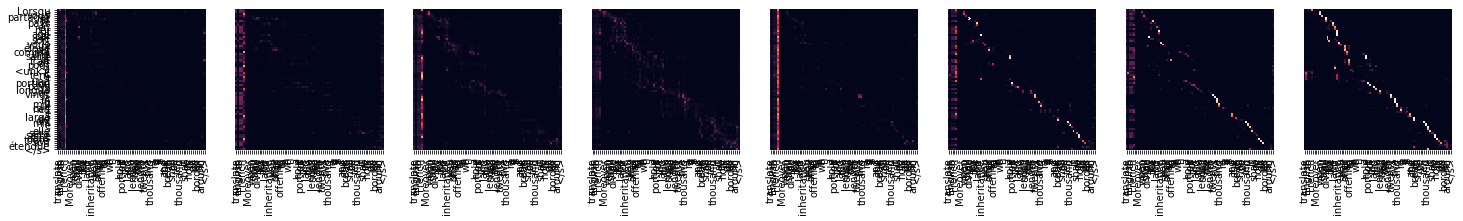

Cross-Layer number : 3


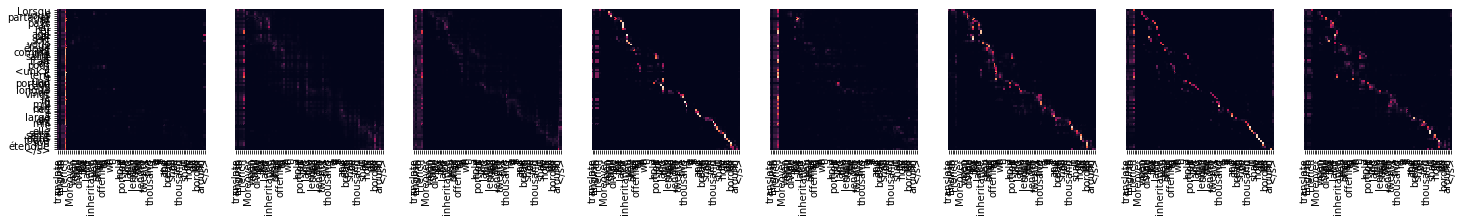

Cross-Layer number : 4


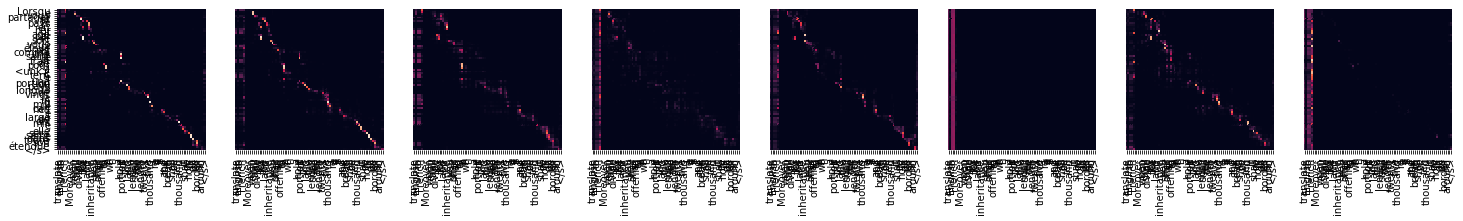

Cross-Layer number : 5


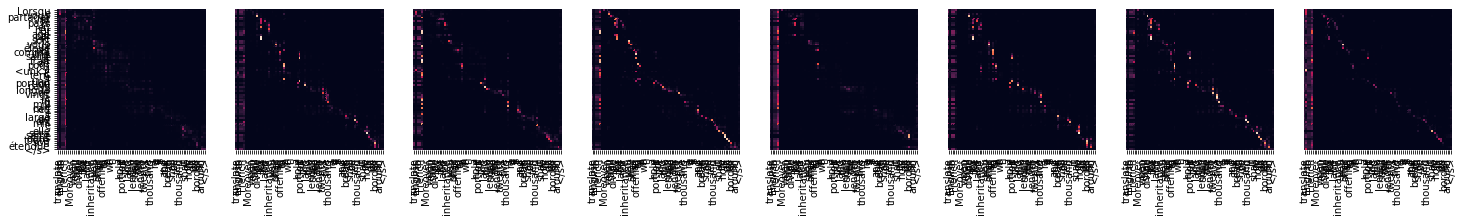

Cross-Layer number : 6


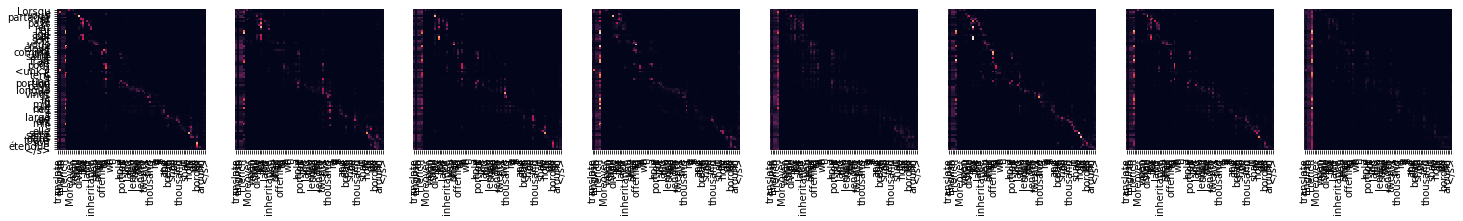

In [ ]:
num_layers = len(outs['cross_attentions'])
for layer in range(num_layers):
    print('Cross-Layer number :', layer+1)
    num_heads = outs['cross_attentions'][layer].shape[1]
    fig, axs = plt.subplots(1,num_heads, figsize=(25, 15))
    for h in range(num_heads):
        draw(outs['cross_attentions'][layer][0, h].data, 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()

### cross-attention matrices for summarization

In [ ]:
# Loading the dataset
dataset_cnn_train = load_dataset("cnn_dailymail", '3.0.0', split='train')
dataset_cnn_valid = load_dataset("cnn_dailymail", '3.0.0', split='validation')
dataset_cnn_test = load_dataset("cnn_dailymail", '3.0.0', split='test')

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0a01b1abede4f646130574f203de57a293ded8a7a11e3406a539453afdfeb2c0)
Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0a01b1abede4f646130574f203de57a293ded8a7a11e3406a539453afdfeb2c0)
Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0a01b1abede4f646130574f203de57a293ded8a7a11e3406a539453afdfeb2c0)


In [ ]:
# Getting the encodings
input_encodings, output_encodings, batch_input, batch_output = pre_processing_summarize(dataset_cnn_test, 1)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3221: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


In [ ]:
outs = model(input_ids=input_encodings['input_ids'], labels=output_encodings['input_ids'], output_attentions=True)
sent = get_sent_from_ids(input_encodings)
tgt_sent = get_sent_from_ids(output_encodings)

Cross-Layer number : 1 , Head number 2


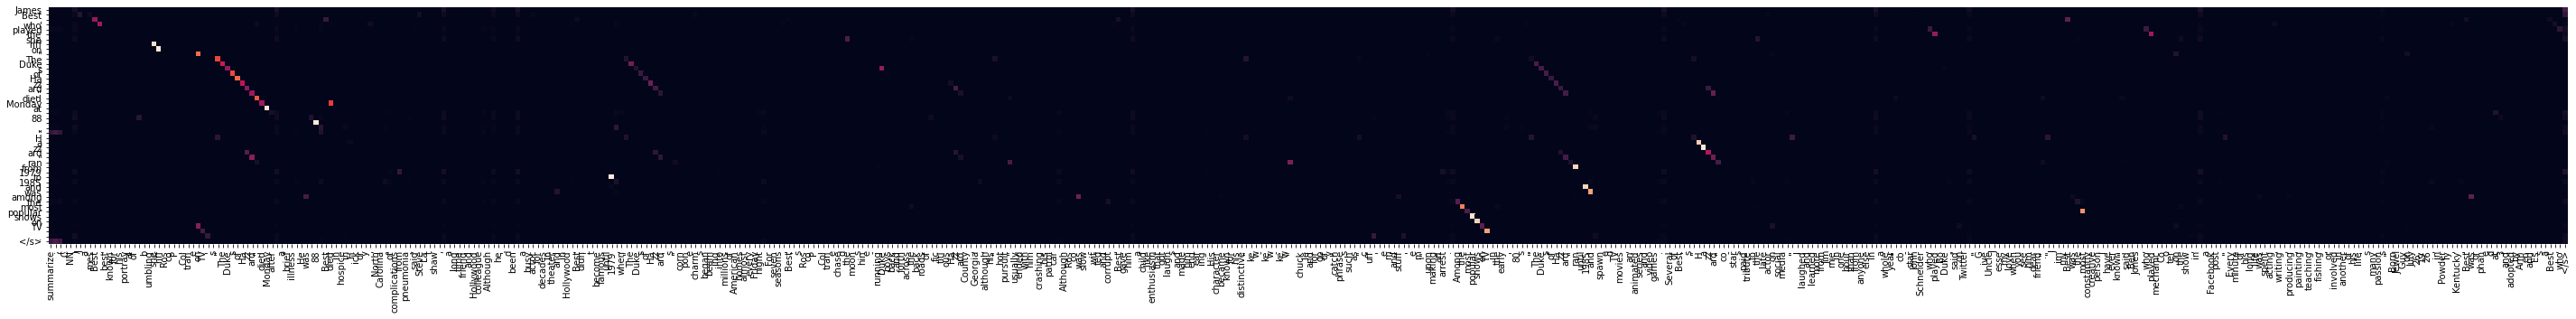

Cross-Layer number : 2 , Head number 4


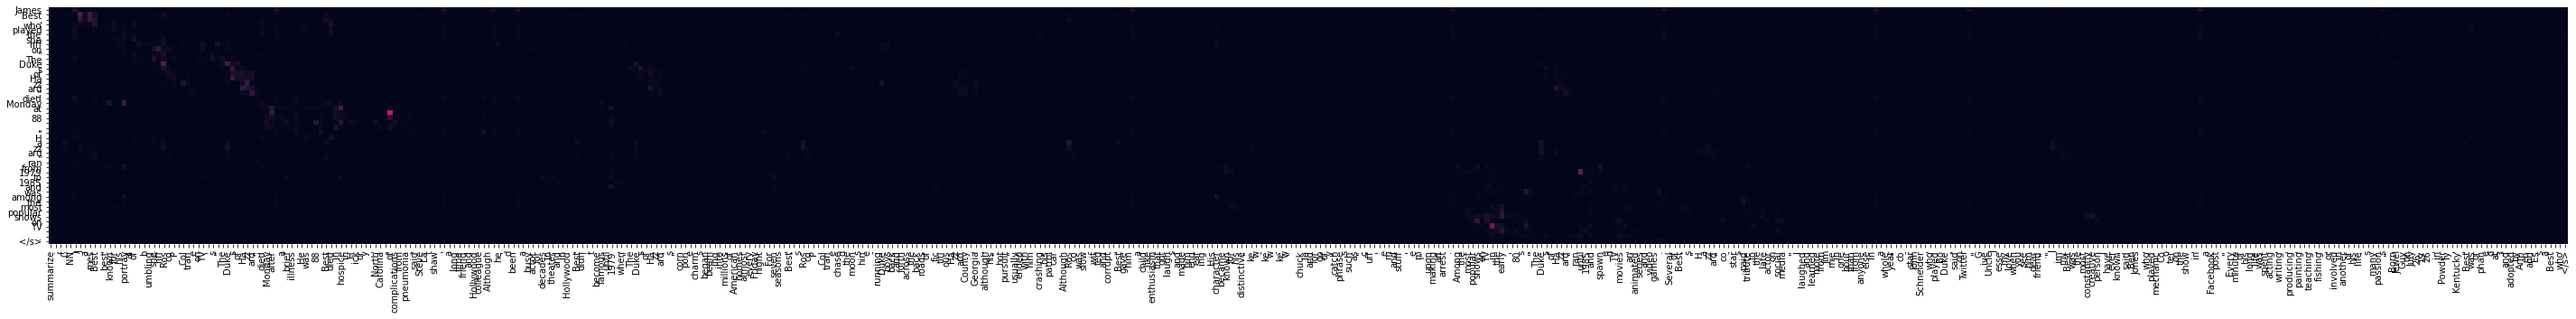

Cross-Layer number : 3 , Head number 4


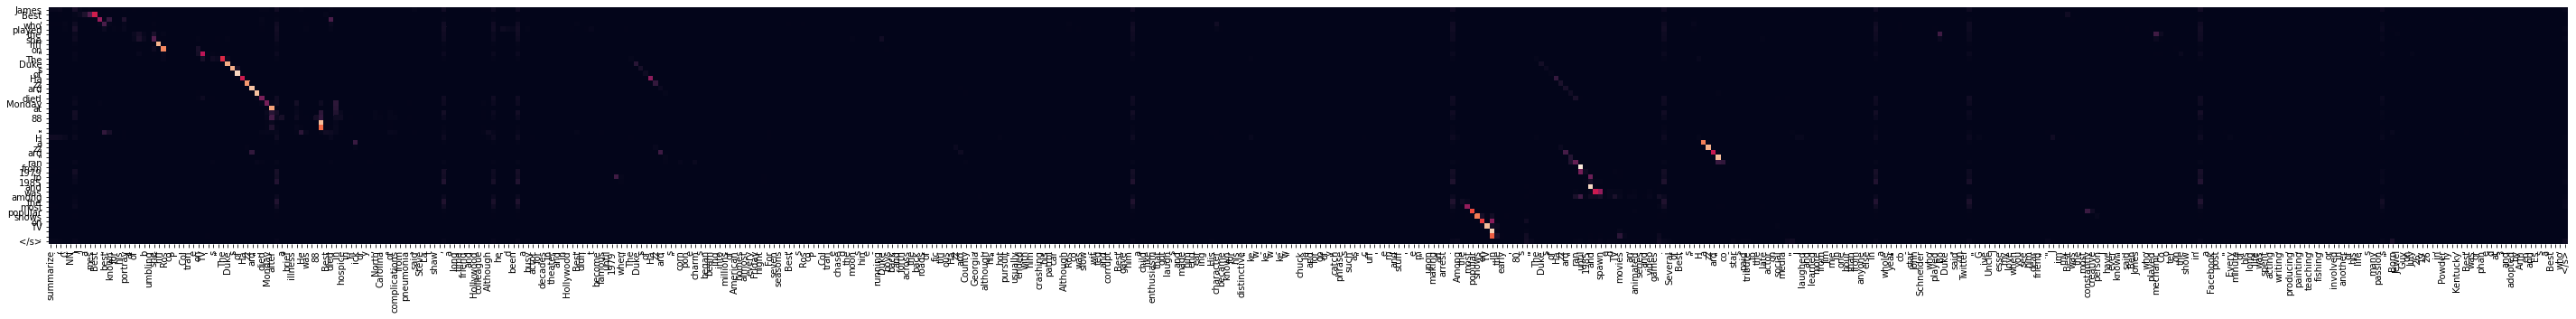

Cross-Layer number : 4 , Head number 3


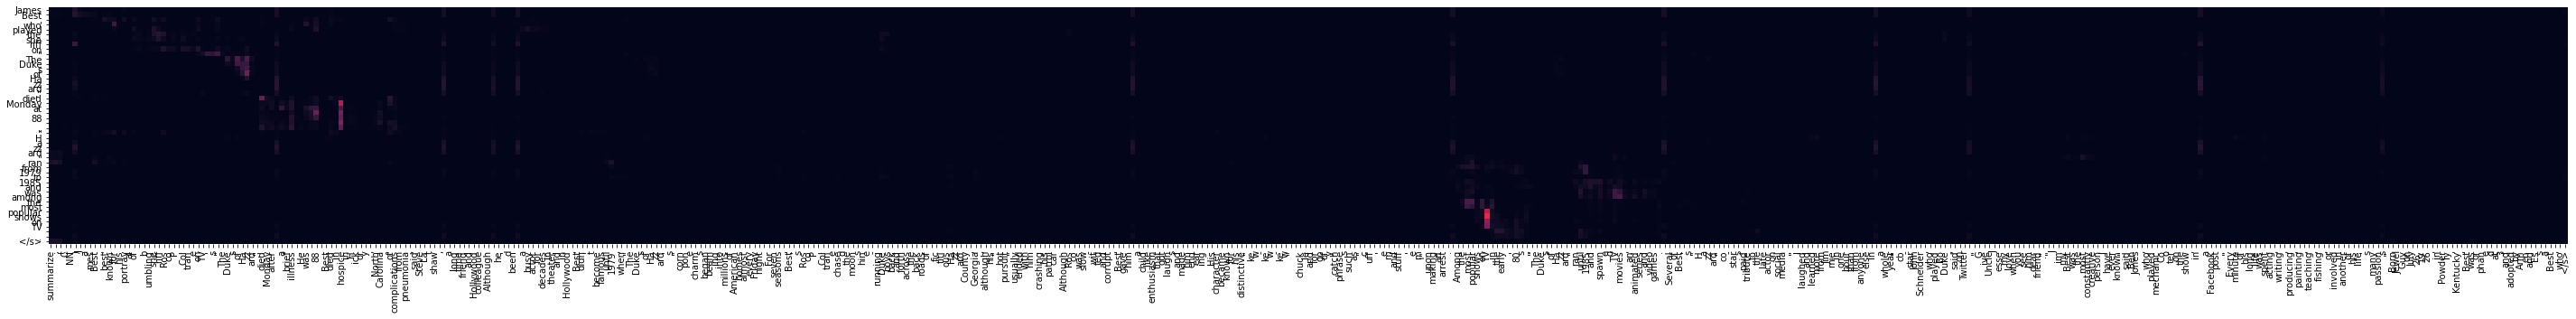

Cross-Layer number : 5 , Head number 2


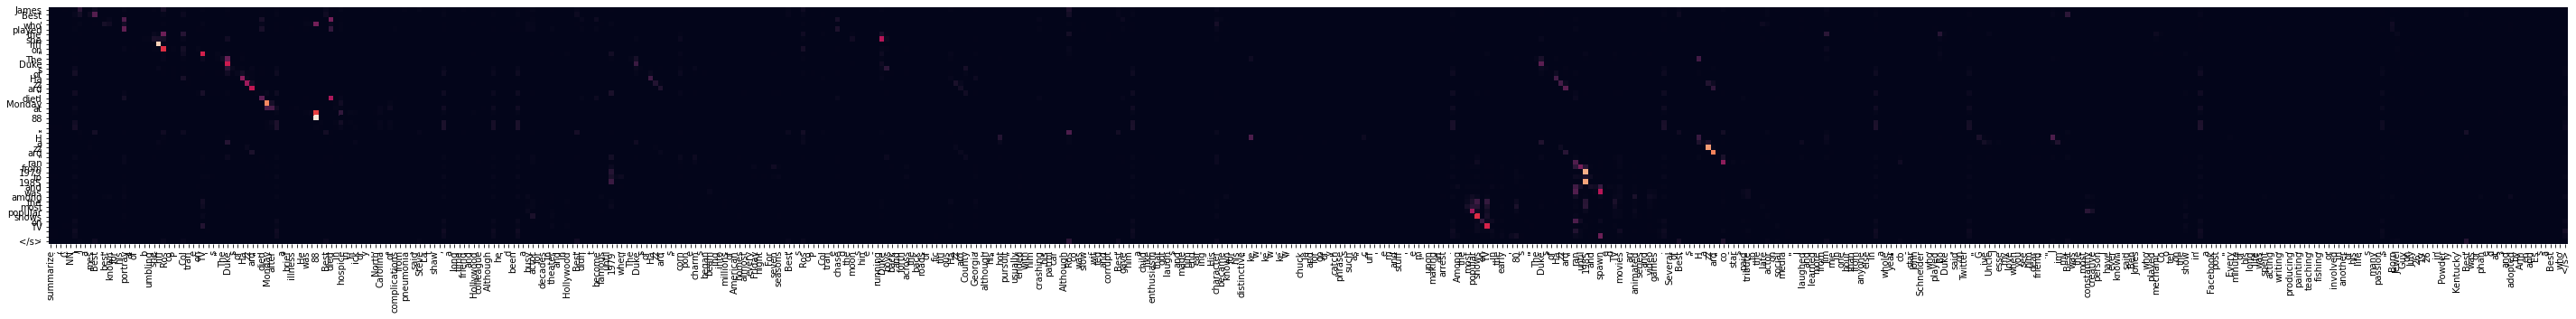

Cross-Layer number : 6 , Head number 1


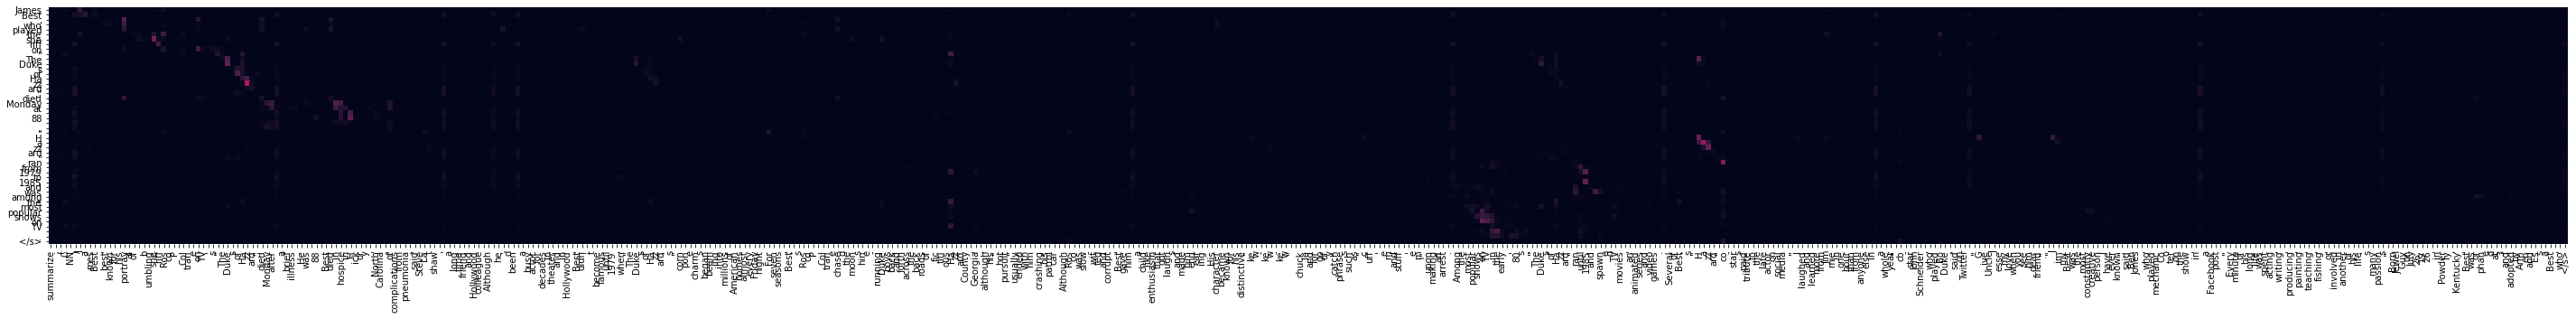

In [ ]:
num_layers = len(outs['cross_attentions'])
chosen_heads = []

for layer in range(num_layers):
    num_heads = outs['cross_attentions'][layer].shape[1]
    fig, ax = plt.subplots(figsize=(50, 50))
    h = random.sample(list(range(num_heads//2)), k=1)[0]
    print('Cross-Layer number :', layer+1, ', Head number', h+1)
    draw(outs['cross_attentions'][layer][0, h].data, 
        sent, tgt_sent, ax=ax)
    chosen_heads.append(h)
    plt.show()

In [ ]:
def return_prob(vector):
    distrib = (vector / sum(vector)).squeeze().tolist()
    error = 1 - sum(distrib)
    idx = np.where(np.array(distrib)>abs(error))[0][0]
    distrib[idx] += error
    return distrib

In [ ]:
input_ids = input_encodings['input_ids'].squeeze().tolist()
input_ids_indices = list(range(len(input_ids)))

for layer in range(num_layers):
    h = chosen_heads[layer]
    print('Cross-Layer number :', layer+1, ', Head number', h+1)
    attn = outs['cross_attentions'][layer][0, h].data
    best_match = attn.argmax(dim=0)

    distrib = return_prob(attn.max(dim=0).values)
    sample_input_ids_indices = np.random.choice(input_ids_indices, size=10, p=distrib)
    sample_input_ids_indices = np.unique(sample_input_ids_indices)

    res = ''
    for input_id_index in sample_input_ids_indices:
        input_id = input_ids[input_id_index]
        token = tokenizer.decode(input_id)
        best_match_id = best_match[input_id_index].item()
        best_match_token = tokenizer.decode(best_match_id)
        res += token
        res += '<=>'
        res += best_match_token
        res += '  ||  '
    print('attention focuses')
    print(res)
    print('\n')

Cross-Layer number : 1 , Head number 2
attention focuses
s<=>of  ||  of<=>fill  ||  Best<=><unk>  ||  <=><pad>  ||  s<=>of  ||  corrupt<=>your  ||  stuff<=>as  ||  on<=>at  ||  ."<=>-  ||  who<=>X  ||  


Cross-Layer number : 2 , Head number 4
attention focuses
Ros<=>and  ||  The<=>:  ||  ,<=>that  ||  Duke<=>e  ||  and<=>en  ||  Among<=>o  ||  the<=>at  ||  "<=>from  ||  H<=>n  ||  star<=>have  ||  


Cross-Layer number : 3 , Head number 4
attention focuses
The<=>:  ||  of<=>of  ||  ick<=>I  ||  ,<=>it  ||  shows<=>or  ||  TV<=>at  ||  in<=>from  ||  co<=>'  ||  .<=>was  ||  


Cross-Layer number : 4 , Head number 3
attention focuses
<=>.  ||  Ros<=>the  ||  Col<=>the  ||  TV<=>a  ||  after<=>that  ||  ick<=>i  ||  complications<=>that  ||  1979<=>'  ||  TV<=>or  ||  


Cross-Layer number : 5 , Head number 2
attention focuses
riff<=>s  ||  Best<=>you  ||  1979<=>en  ||  Duke<=>and  ||  Best<=>you  ||  <=>that  ||  ard<=>in  ||  zz<=>with  ||  ard<=>n  ||  Best<=>was  ||  


Cross-Laye

### cross-attention matrices for QA

In [ ]:
# Loading the dataset
dataset_bool_train, dataset_bool_valid, dataset_bool_test = build_bataset_bool("boolq")

Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Loading cached split indices for dataset at /root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534/cache-7c824eef092cd93a.arrow and /root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534/cache-e785ff6ef111fb39.arrow


In [ ]:
input_encodings, output_encodings, batch_input, batch_output = pre_processing_qa(dataset_bool_test, 1)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3221: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:175: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


In [ ]:
outs = model(input_ids=input_encodings['input_ids'], labels=output_encodings['input_ids'], output_attentions=True)
sent = get_sent_from_ids(input_encodings)
tgt_sent = get_sent_from_ids(output_encodings)

In [ ]:
' '.join(sent)

'question : can you have twin s from 2 different dad s context : Super f e c und ation is the fertiliz ation of two or more  ova from the same cycle by  sper m from separate acts of sexual inter course , which can lead to twin babies from two separate biological father s . The term super f e c und ation is  derived from  f e c und , meaning the ability to produce off spring . He t e rop a tern al super f e c und ation refer s to the fertiliz ation of two separate  ova by two different father s . Ho m o p a tern al super f e c und ation refer s to the fertiliz ation of two separate  ova from the same father , leading to fra tern al twin s . While hetero p a tern al super f e c und ation is  referred to as  a form of  a typical  t winning , genetic ally , the twin s are half siblings . Super f e c und ation , while rare , can occur through either separate  occurrence s of sexual inter course or through artificial in s e mination . </s>'

Cross-Layer number : 1 , Head number 4


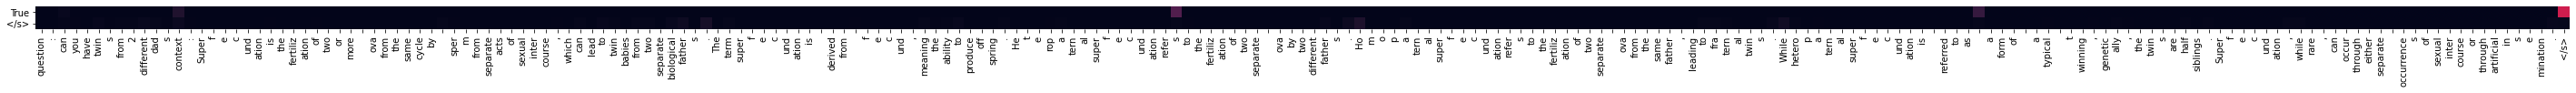

Cross-Layer number : 2 , Head number 4


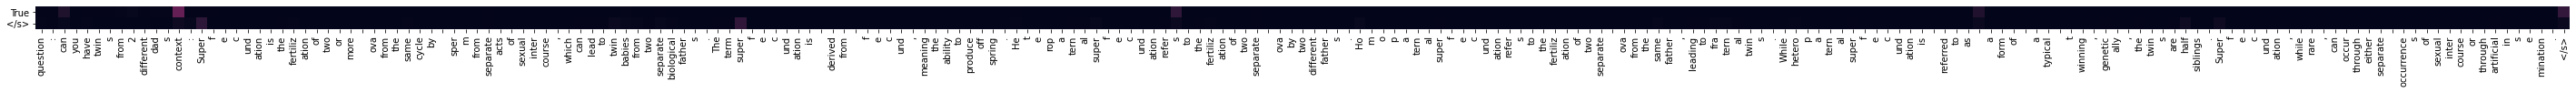

Cross-Layer number : 3 , Head number 1


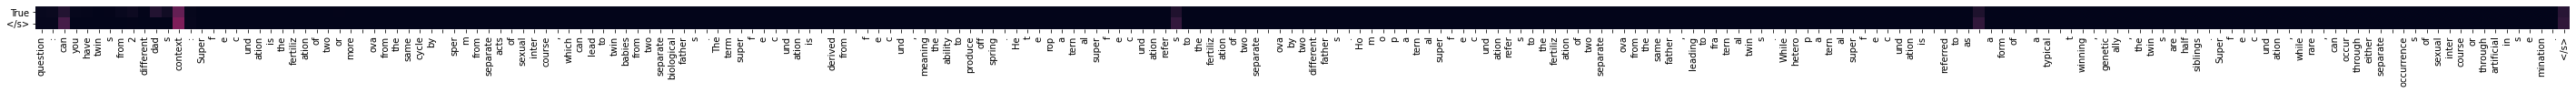

Cross-Layer number : 4 , Head number 4


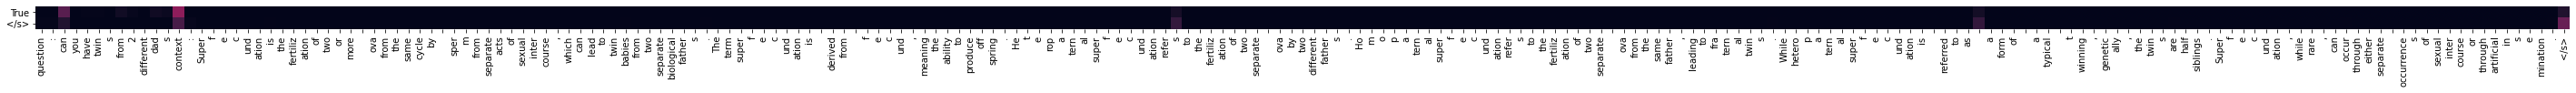

Cross-Layer number : 5 , Head number 3


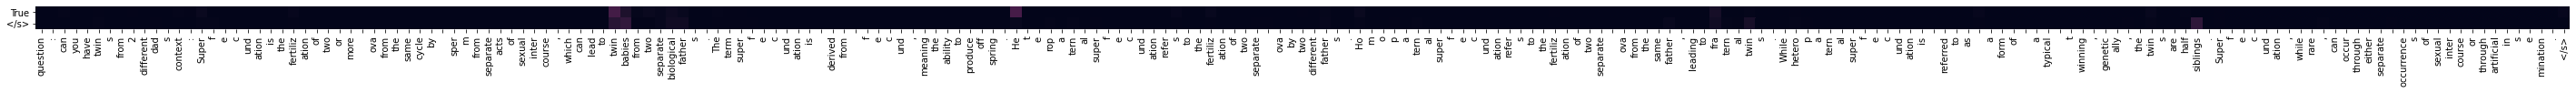

Cross-Layer number : 6 , Head number 2


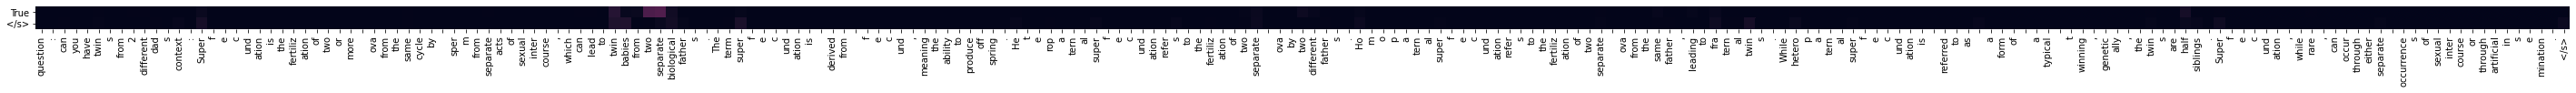

In [ ]:
num_layers = len(outs['cross_attentions'])
chosen_heads = []

for layer in range(num_layers):
    num_heads = outs['cross_attentions'][layer].shape[1]
    fig, ax = plt.subplots(figsize=(50, 50))
    h = random.sample(list(range(num_heads//2)), k=1)[0]
    print('Cross-Layer number :', layer+1, ', Head number', h+1)
    draw(outs['cross_attentions'][layer][0, h].data, 
        sent, tgt_sent, ax=ax)
    chosen_heads.append(h)
    plt.show()

### Aggregated attention values across heads/layers for translation

In [ ]:
# Loading the dataset
dataset_bible = load_dataset("bible_para", lang1="en", lang2="fr", split='train')

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


In [ ]:
# Splitting the data into the training set, the valid set and the test set
dataset_train, dataset_valid, dataset_test = buil_bataset(dataset_bible)

Loading cached split indices for dataset at /root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1/cache-b00b102888764796.arrow and /root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1/cache-deafbd0ad675f64a.arrow
Loading cached split indices for dataset at /root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1/cache-b912696bfc649777.arrow and /root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1/cache-26f2b0387b1ab262.arrow


In [ ]:
# Loading the model
model = T5ForConditionalGeneration.from_pretrained('t5-small', return_dict=True)
print('Model loaded!')

Model loaded!


In [ ]:
# Getting the input and output encodings according to the tokenizer of t5-small
tokenizer = T5Tokenizer.from_pretrained('t5-small')
input_encodings, output_encodings, batch_input, batch_output = pre_processing(dataset_test, 1)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3221: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


In [ ]:
outs = model(input_ids=input_encodings['input_ids'], labels=output_encodings['input_ids'], output_attentions=True)
sent = get_sent_from_ids(input_encodings)
tgt_sent = get_sent_from_ids(output_encodings)

In [ ]:
print('English sentence')
print(' '.join(sent))
print('French sentence')
print(' '.join(tgt_sent))

English sentence
translate English to French : But blessed are your eyes , for they see : and your ears , for they hear . </s>
French sentence
Mais heureux sont vos yeux , parce qu <unk> ils voi ent ,  e t vos  oreille s , parce qu <unk> elles  entend ent ! </s>


##### Aggregated per head

Aggregated heads at layer : 1


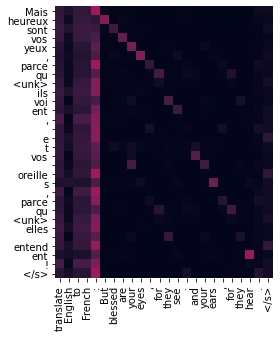

Aggregated heads at layer : 2


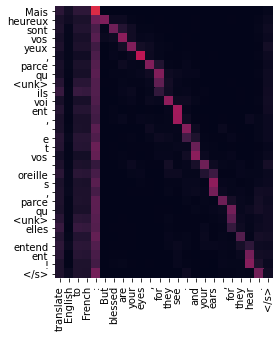

Aggregated heads at layer : 3


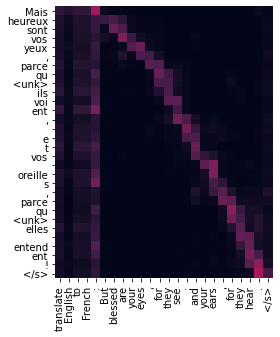

Aggregated heads at layer : 4


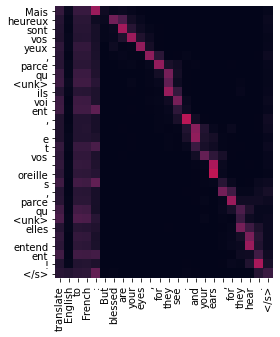

Aggregated heads at layer : 5


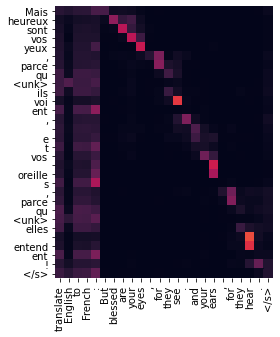

Aggregated heads at layer : 6


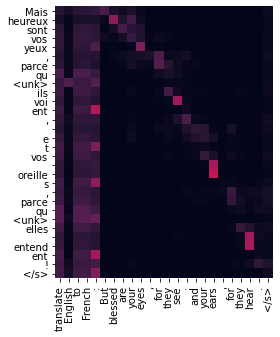

In [ ]:
num_layers = len(outs['cross_attentions'])
for layer in range(num_layers):
    print('Aggregated heads at layer :', layer+1)
    num_heads = outs['cross_attentions'][layer].shape[1]
    fig, axs = plt.subplots(figsize=(5, 5))
    attn = torch.zeros(len(tgt_sent), len(sent))
    for h in range(num_heads):
        attn += outs['cross_attentions'][layer][0, h].data
    draw(attn/num_heads, 
        sent, tgt_sent, ax=axs)
    plt.show()

##### Aggregated per layer

Aggregated layers at head : 1


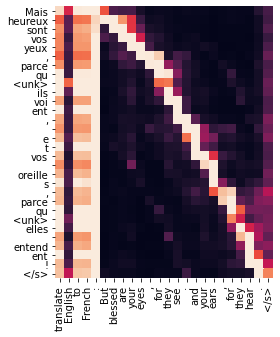

Aggregated layers at head : 2


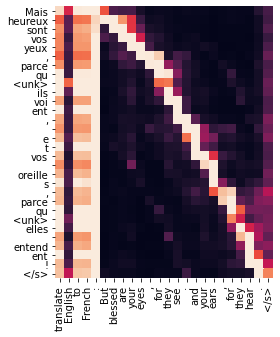

Aggregated layers at head : 3


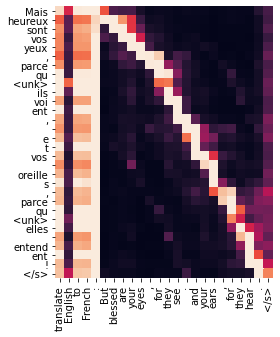

Aggregated layers at head : 4


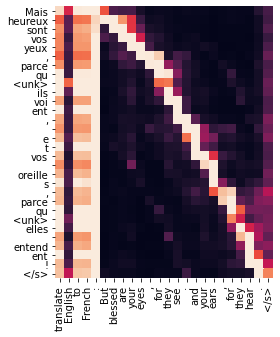

Aggregated layers at head : 5


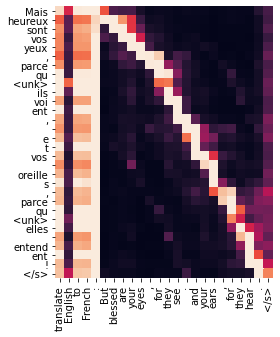

Aggregated layers at head : 6


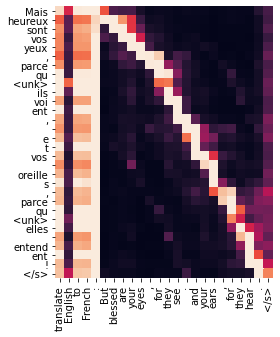

Aggregated layers at head : 7


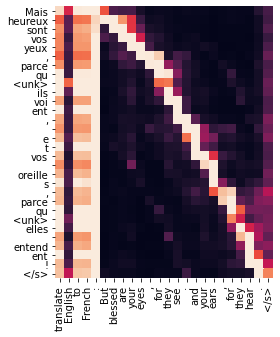

Aggregated layers at head : 8


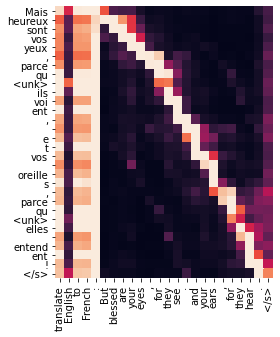

In [ ]:
num_layers = len(outs['cross_attentions'])
num_heads = outs['cross_attentions'][0].shape[1]
attn = [torch.zeros(len(tgt_sent), len(sent))]*num_heads

for layer in range(num_layers):
    num_heads = outs['cross_attentions'][layer].shape[1]
    for h in range(num_heads):
        attn[h] += outs['cross_attentions'][layer][0, h].data
for h in range(num_heads):
    print('Aggregated layers at head :', h+1)
    fig, axs = plt.subplots(figsize=(5, 5))
    draw(attn[layer]/num_layers, 
        sent, tgt_sent, ax=axs)
    plt.show()

### Aggregated attention values across heads/layers for summarization

In [ ]:
# Loading the dataset
dataset_cnn_train = load_dataset("cnn_dailymail", '3.0.0', split='train')
dataset_cnn_valid = load_dataset("cnn_dailymail", '3.0.0', split='validation')
dataset_cnn_test = load_dataset("cnn_dailymail", '3.0.0', split='test')

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0a01b1abede4f646130574f203de57a293ded8a7a11e3406a539453afdfeb2c0)
Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0a01b1abede4f646130574f203de57a293ded8a7a11e3406a539453afdfeb2c0)
Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0a01b1abede4f646130574f203de57a293ded8a7a11e3406a539453afdfeb2c0)


In [ ]:
# Getting the encodings
input_encodings, output_encodings, batch_input, batch_output = pre_processing_summarize(dataset_cnn_test, 1)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3221: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


In [ ]:
outs = model(input_ids=input_encodings['input_ids'], labels=output_encodings['input_ids'], output_attentions=True)
sent = get_sent_from_ids(input_encodings)
tgt_sent = get_sent_from_ids(output_encodings)

##### Aggregated per head

Aggregated heads at layer : 1


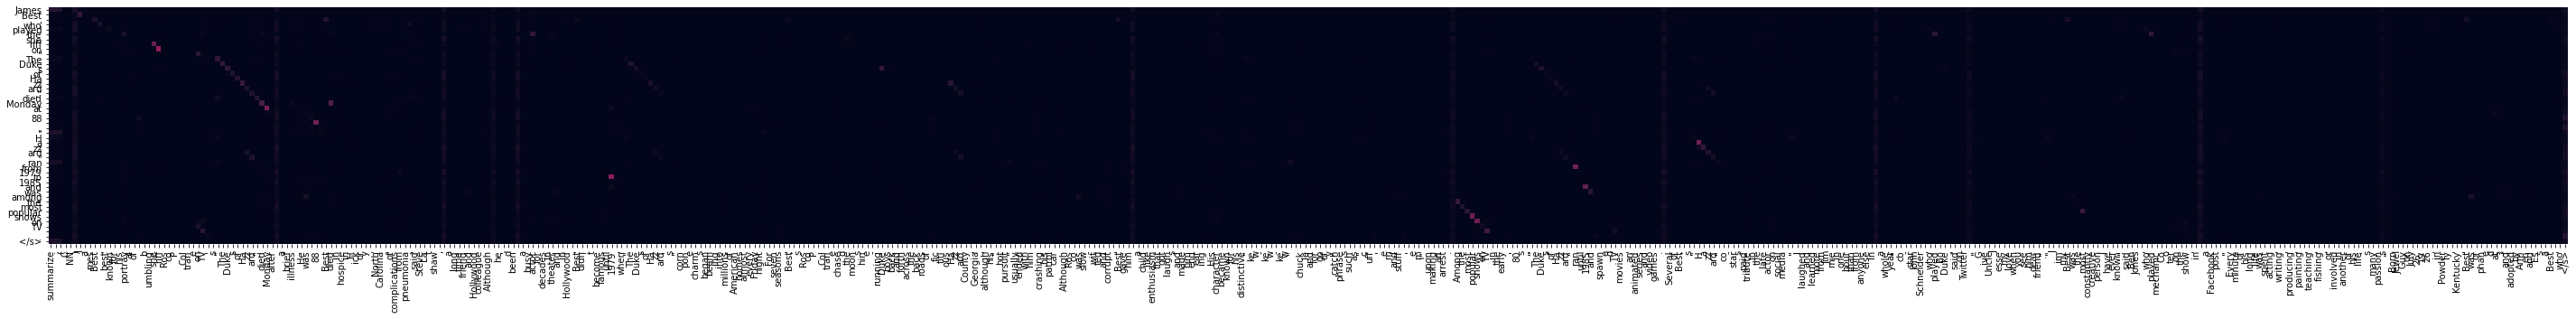

Aggregated heads at layer : 2


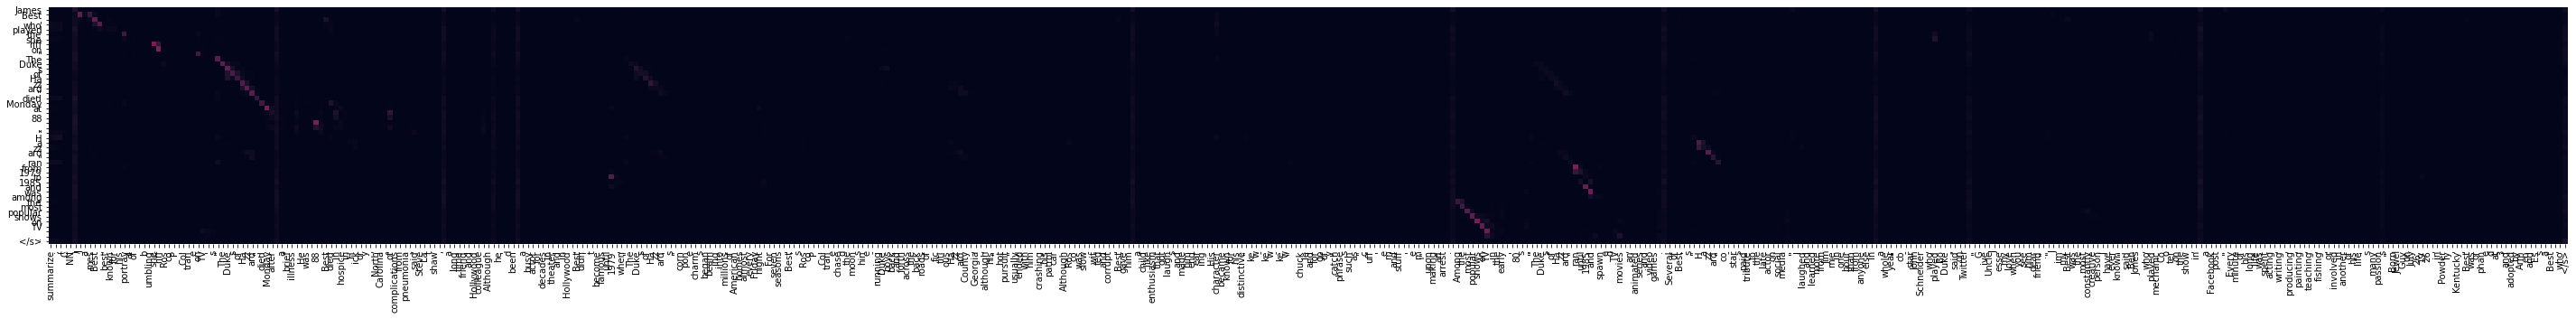

Aggregated heads at layer : 3


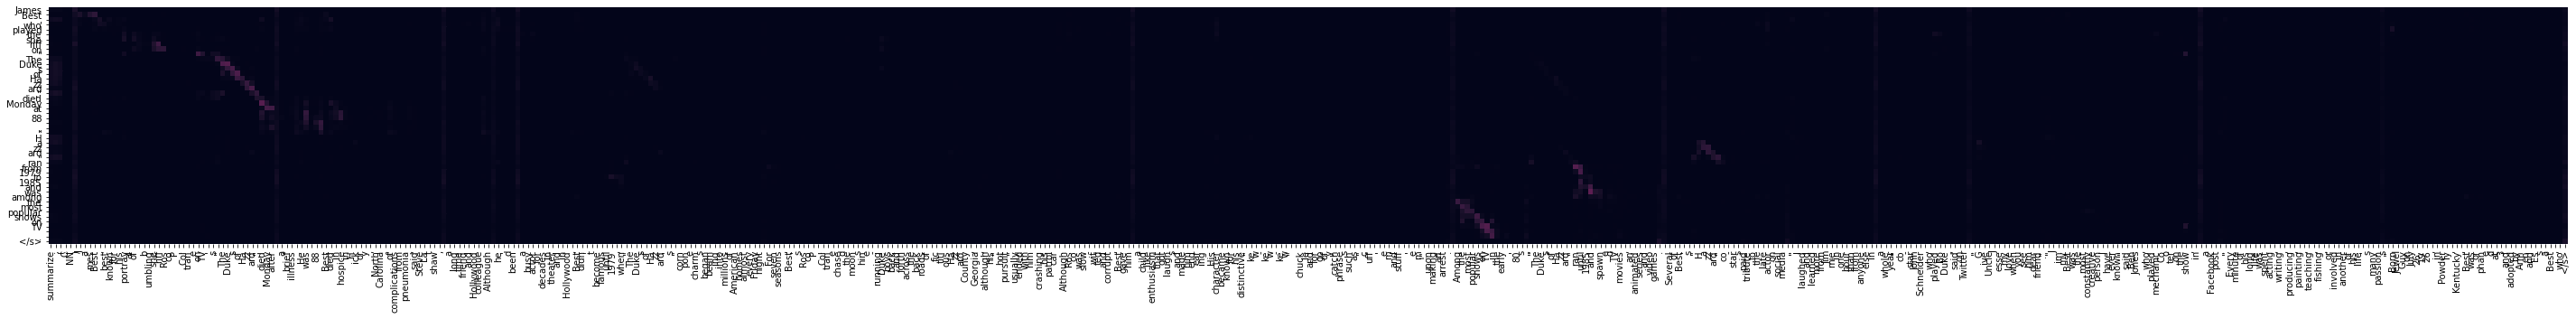

Aggregated heads at layer : 4


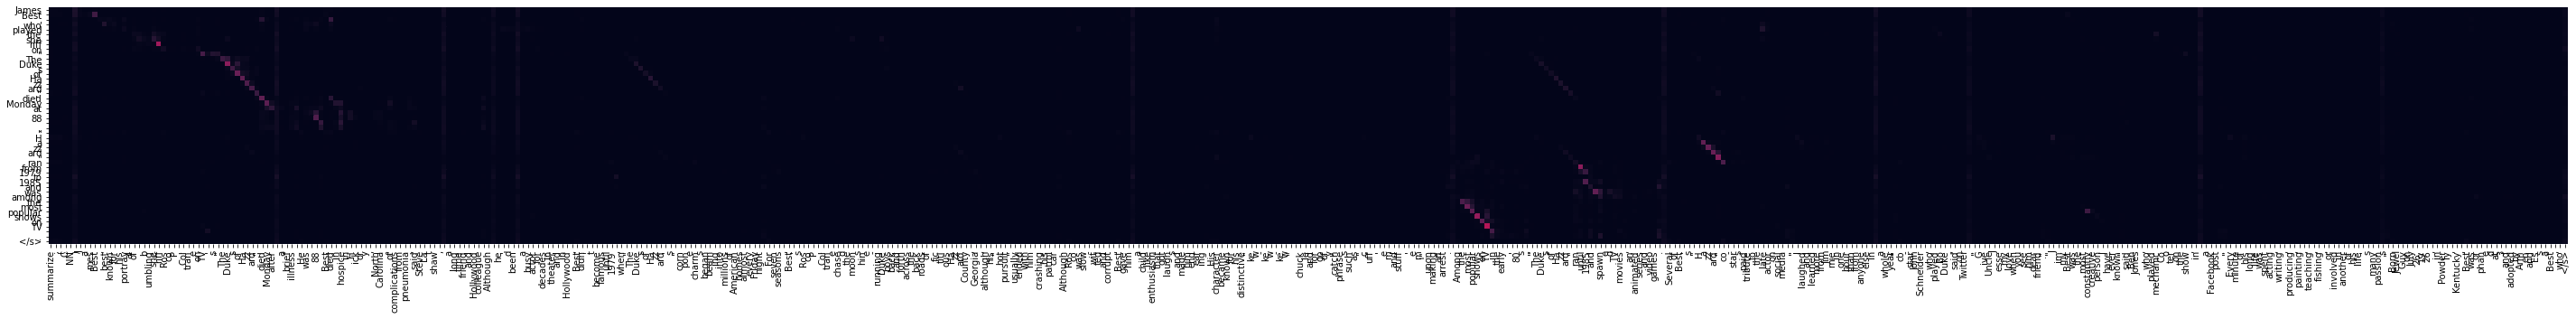

Aggregated heads at layer : 5


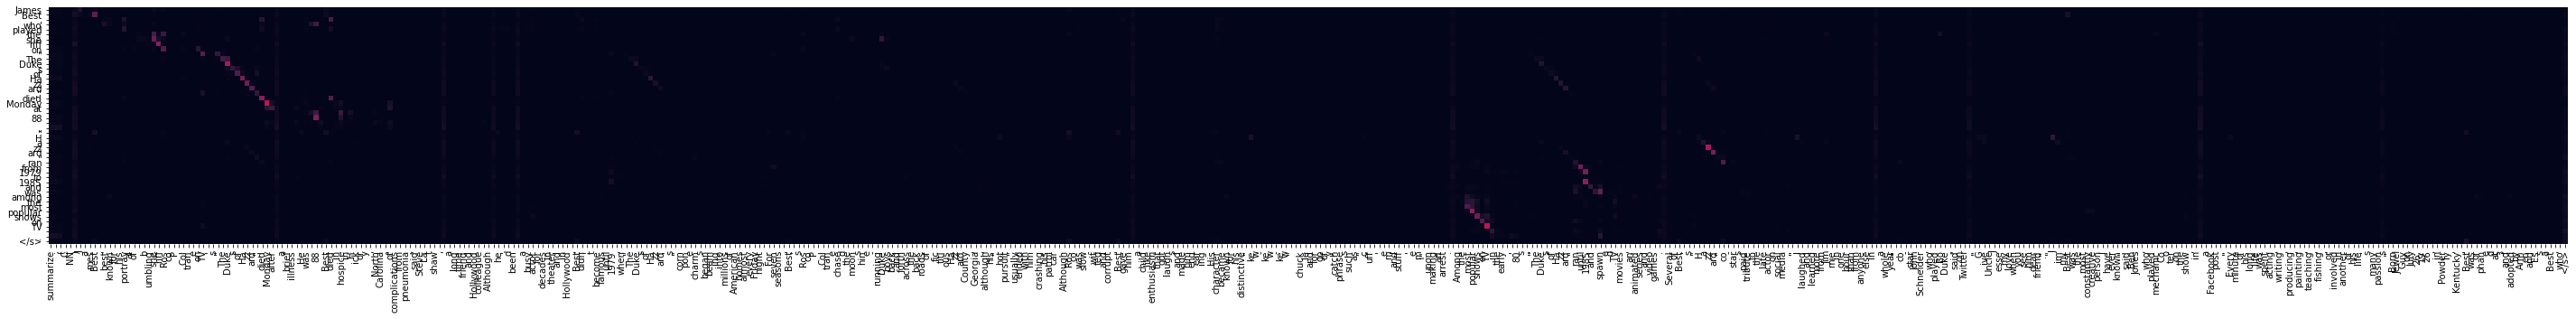

Aggregated heads at layer : 6


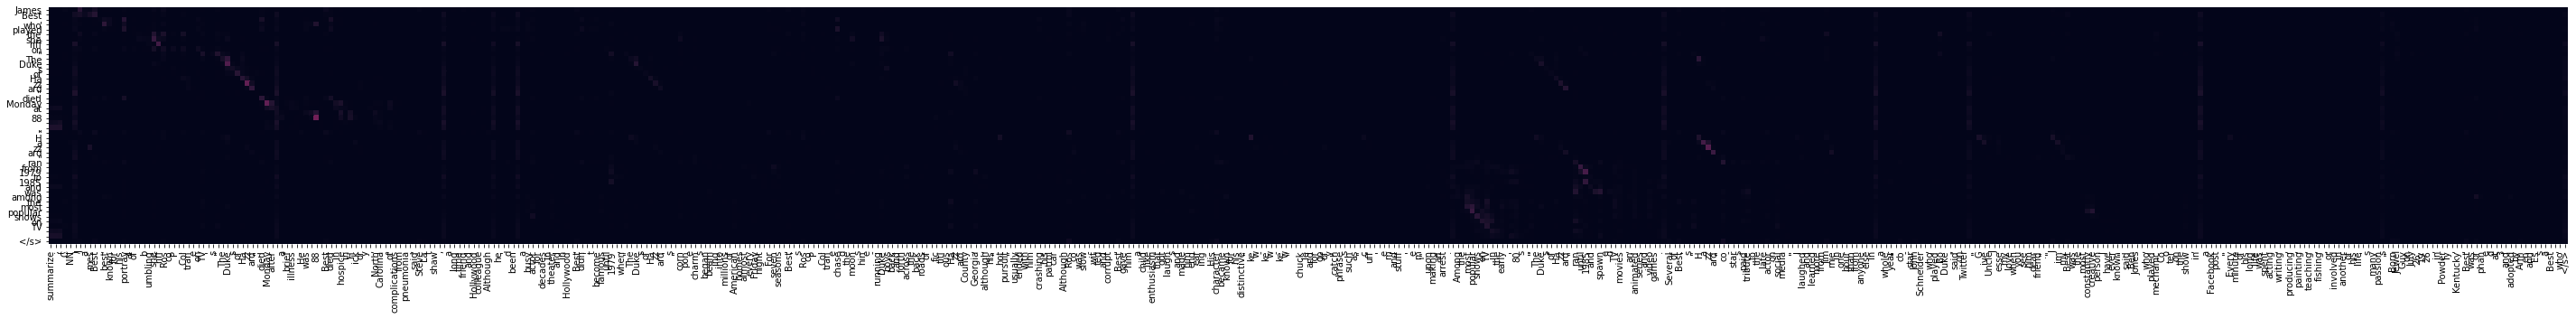

In [ ]:
num_layers = len(outs['cross_attentions'])
for layer in range(num_layers):
    print('Aggregated heads at layer :', layer+1)
    num_heads = outs['cross_attentions'][layer].shape[1]
    fig, axs = plt.subplots(figsize=(50, 50))
    attn = torch.zeros(len(tgt_sent), len(sent))
    for h in range(num_heads):
        attn += outs['cross_attentions'][layer][0, h].data
    draw(attn/num_heads, 
        sent, tgt_sent, ax=axs)
    plt.show()

##### Aggregated per layer

Aggregated layers at head : 1


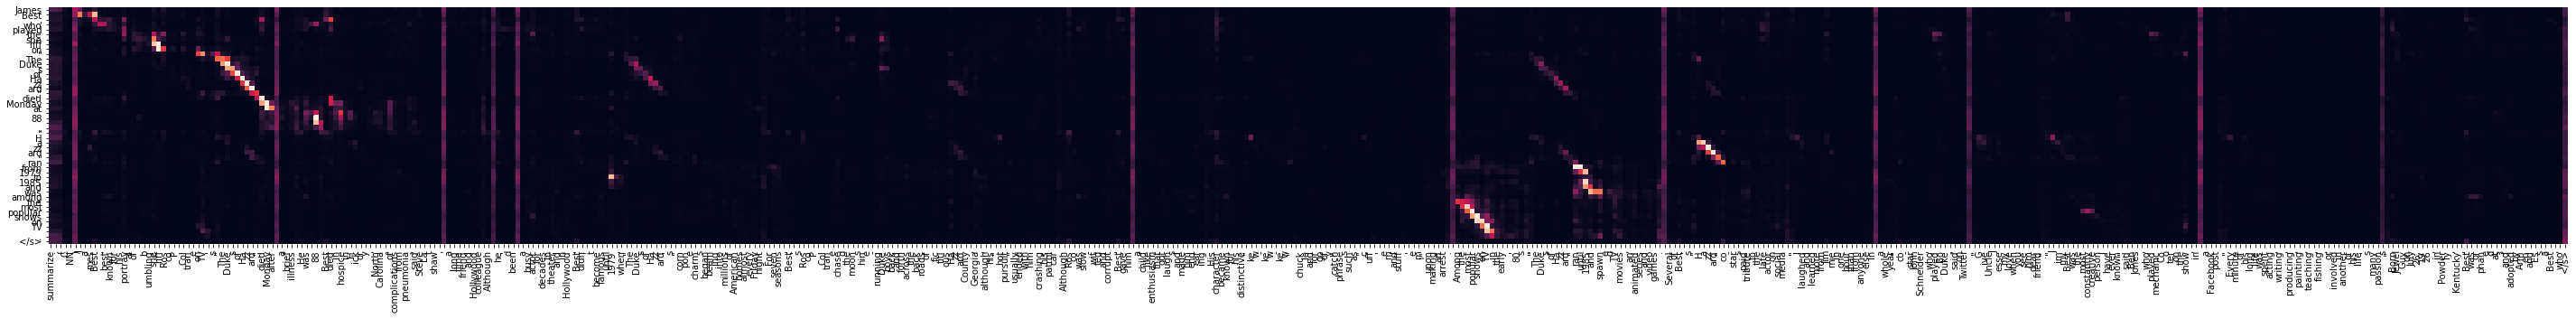

Aggregated layers at head : 2


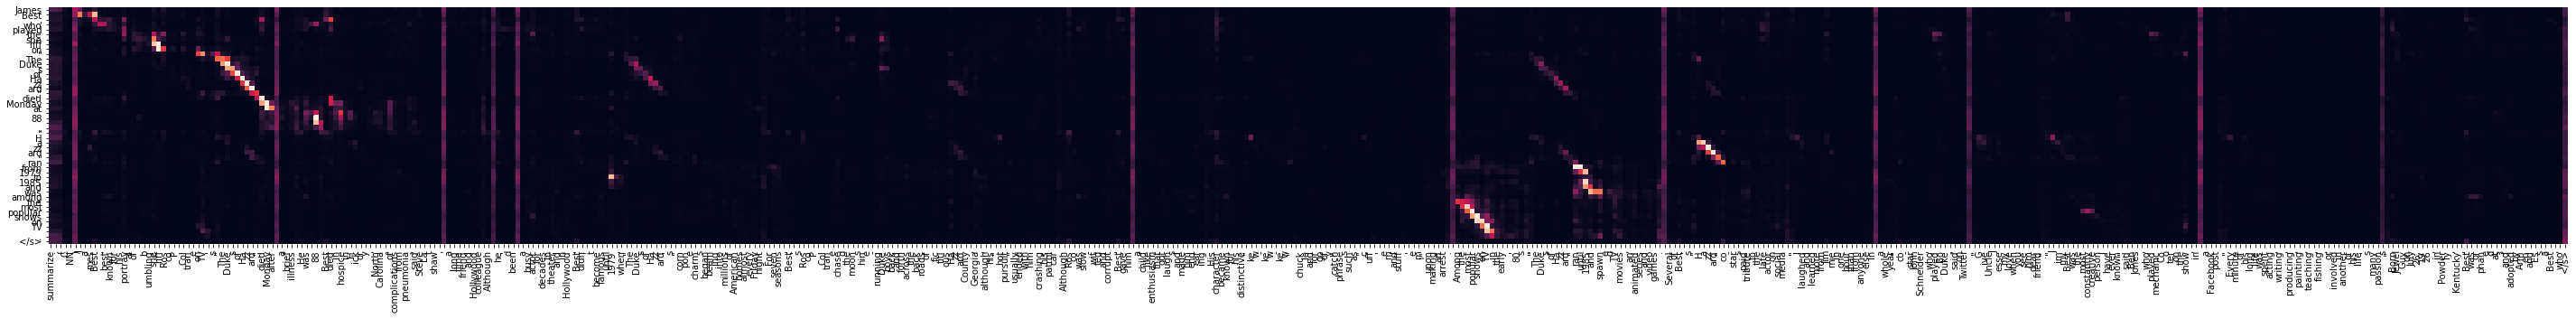

Aggregated layers at head : 3


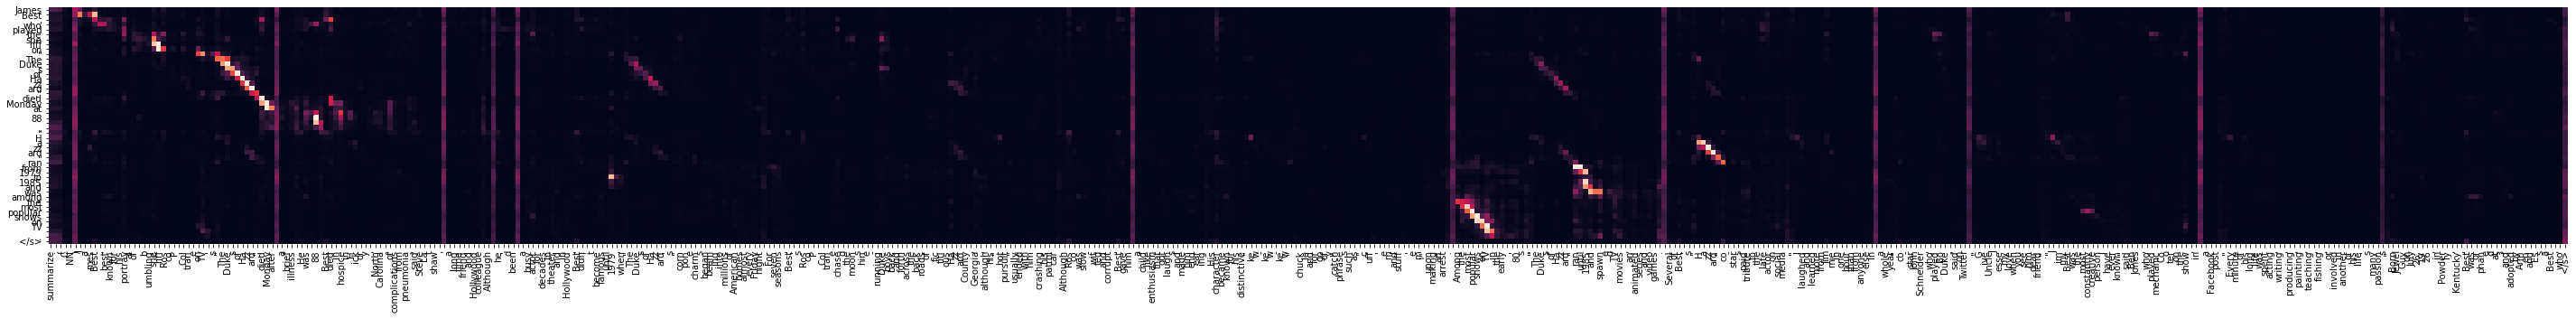

Aggregated layers at head : 4


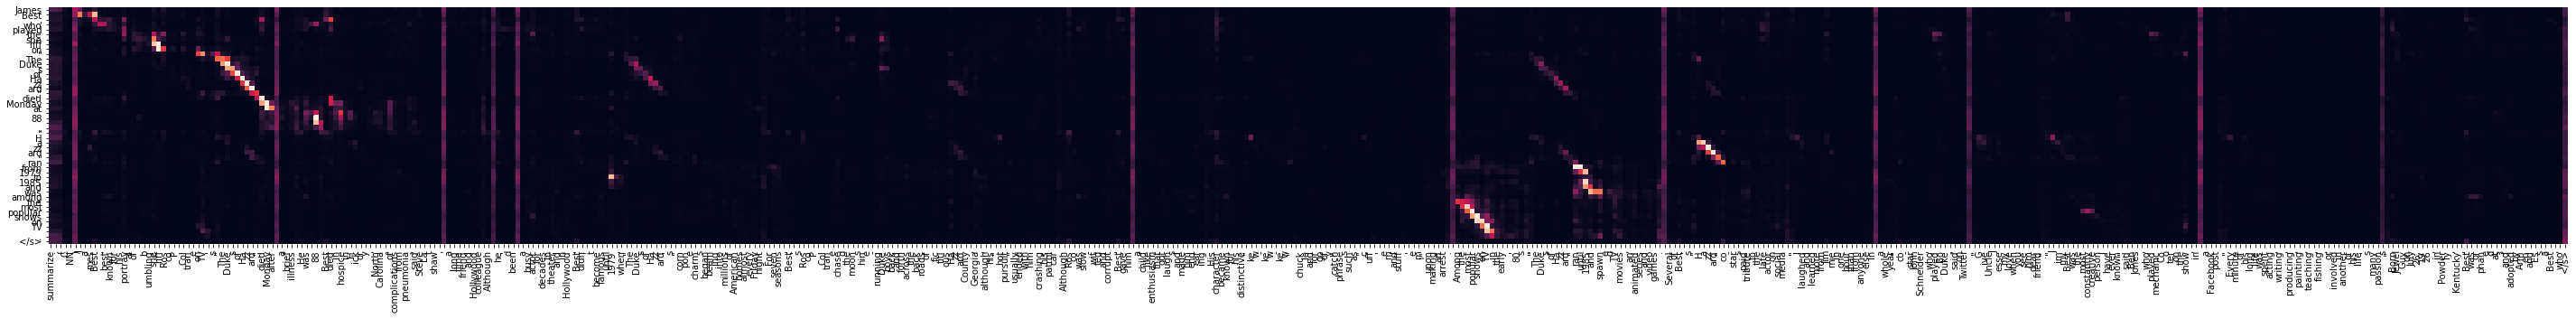

Aggregated layers at head : 5


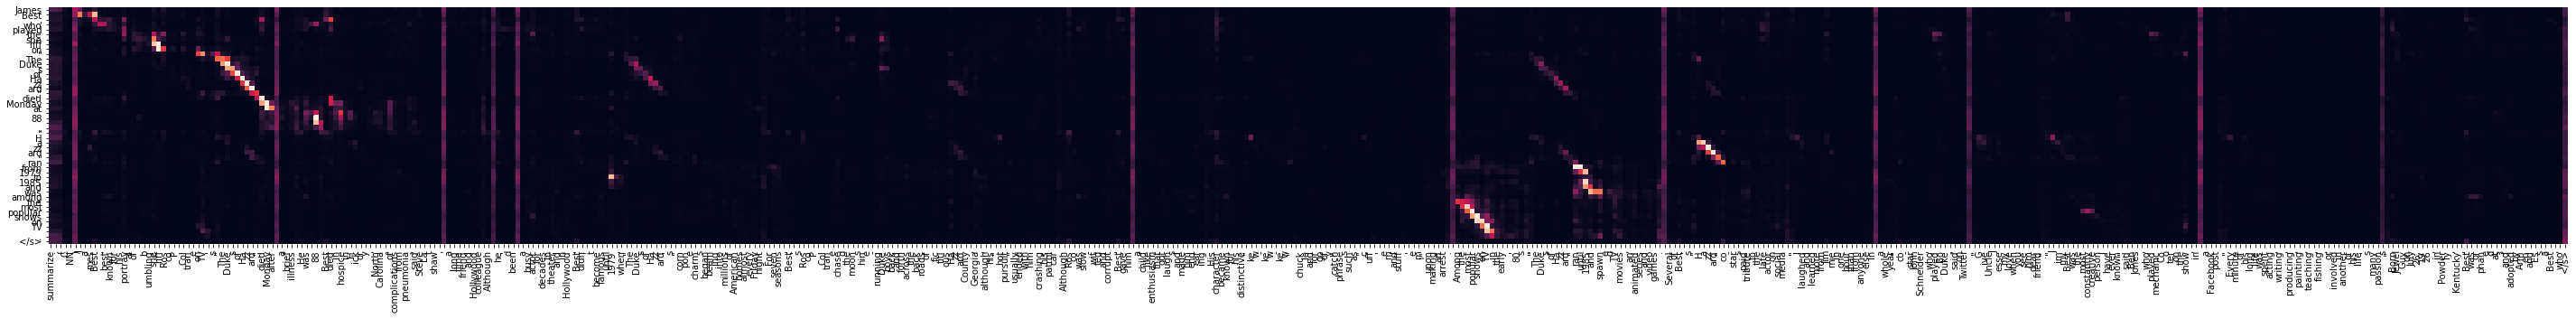

Aggregated layers at head : 6


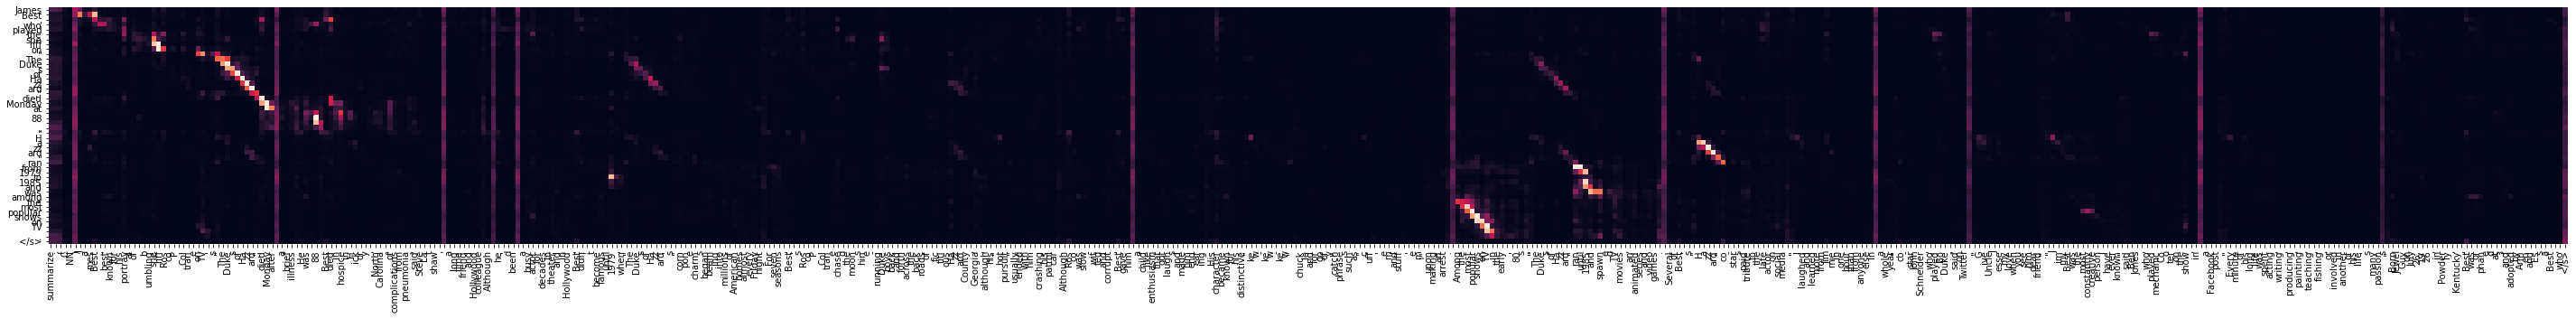

Aggregated layers at head : 7


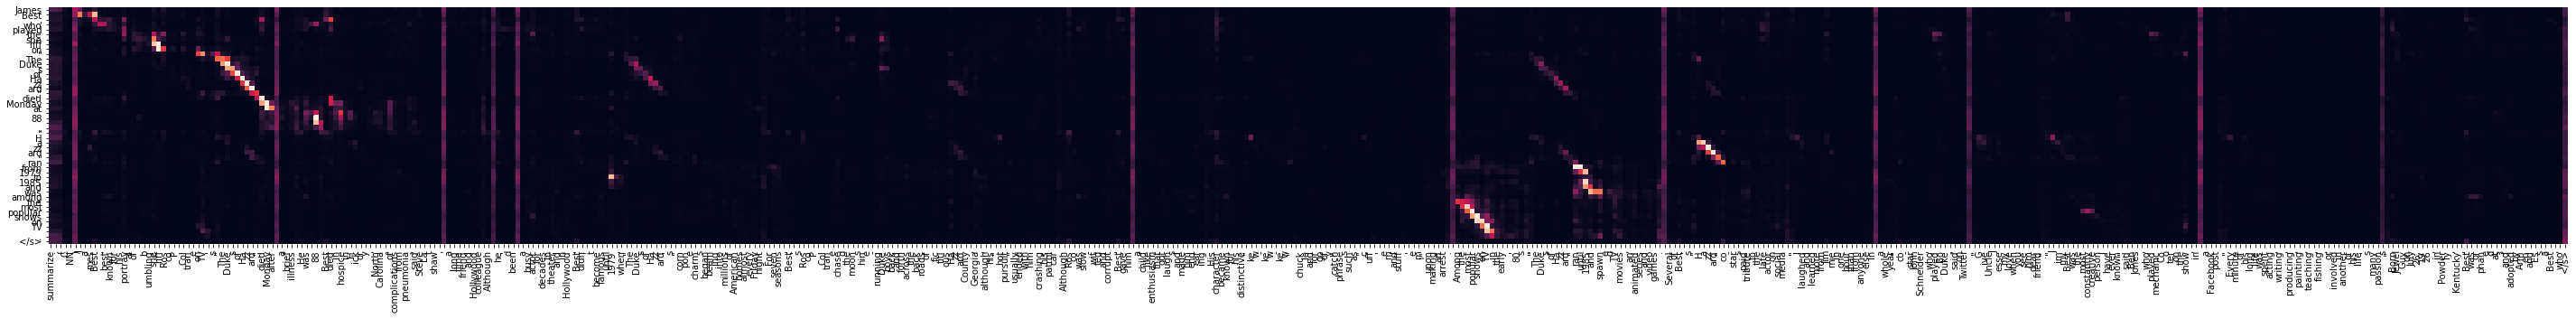

Aggregated layers at head : 8


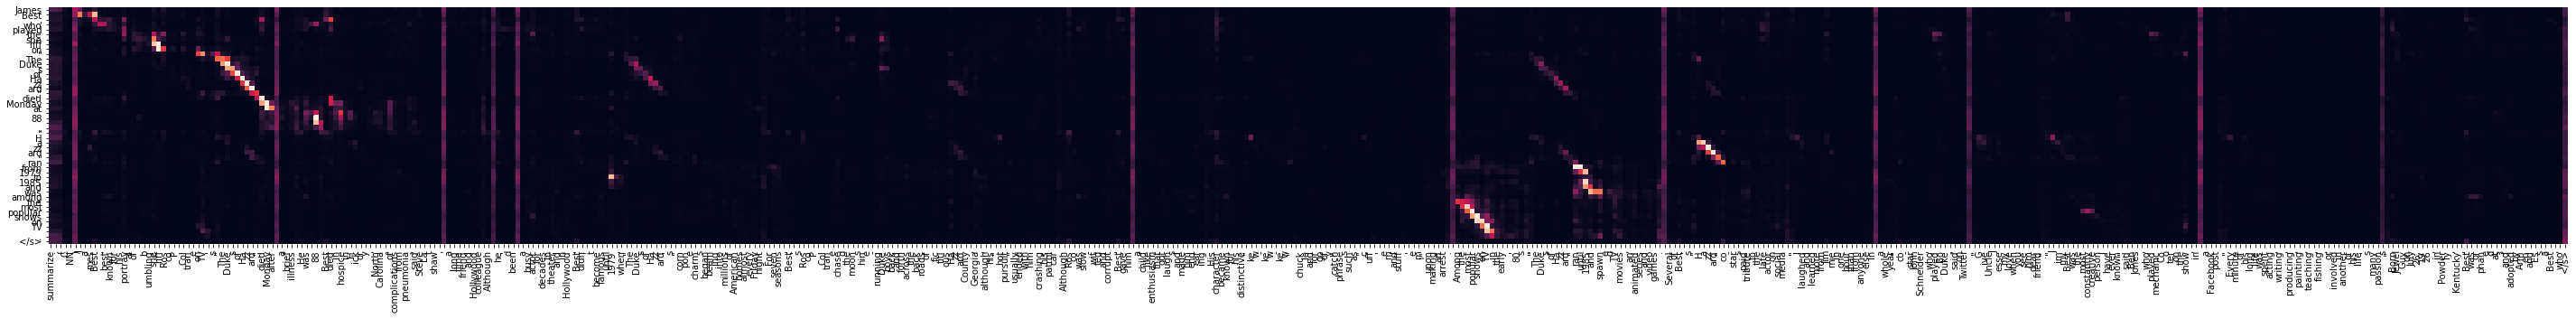

In [ ]:
num_layers = len(outs['cross_attentions'])
num_heads = outs['cross_attentions'][0].shape[1]
attn = [torch.zeros(len(tgt_sent), len(sent))]*num_heads

for layer in range(num_layers):
    num_heads = outs['cross_attentions'][layer].shape[1]
    for h in range(num_heads):
        attn[h] += outs['cross_attentions'][layer][0, h].data
for h in range(num_heads):
    print('Aggregated layers at head :', h+1)
    fig, axs = plt.subplots(figsize=(50, 50))
    draw(attn[layer]/num_layers, 
        sent, tgt_sent, ax=axs)
    plt.show()

### Aggregated attention values across heads/layers for QA

In [ ]:
# Loading the dataset
dataset_bool_train, dataset_bool_valid, dataset_bool_test = build_bataset_bool("boolq")

Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Loading cached split indices for dataset at /root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534/cache-7c824eef092cd93a.arrow and /root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534/cache-e785ff6ef111fb39.arrow


In [ ]:
input_encodings, output_encodings, batch_input, batch_output = pre_processing_qa(dataset_bool_test, 1)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3221: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:175: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


In [ ]:
outs = model(input_ids=input_encodings['input_ids'], labels=output_encodings['input_ids'], output_attentions=True)
sent = get_sent_from_ids(input_encodings)
tgt_sent = get_sent_from_ids(output_encodings)

##### Aggregated per head

Aggregated heads at layer : 1


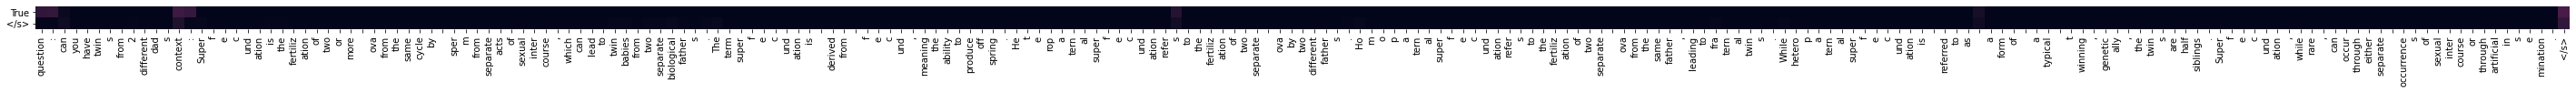

Aggregated heads at layer : 2


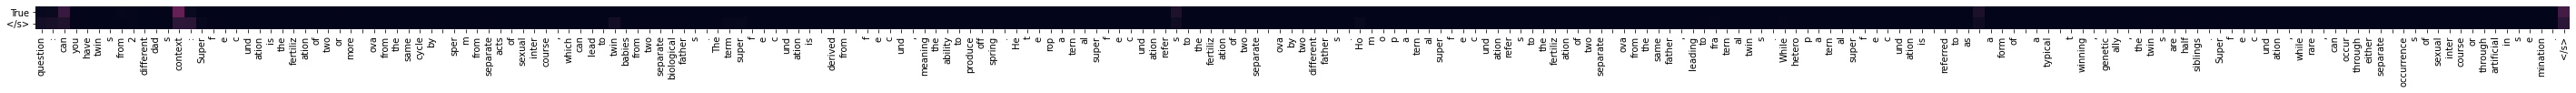

Aggregated heads at layer : 3


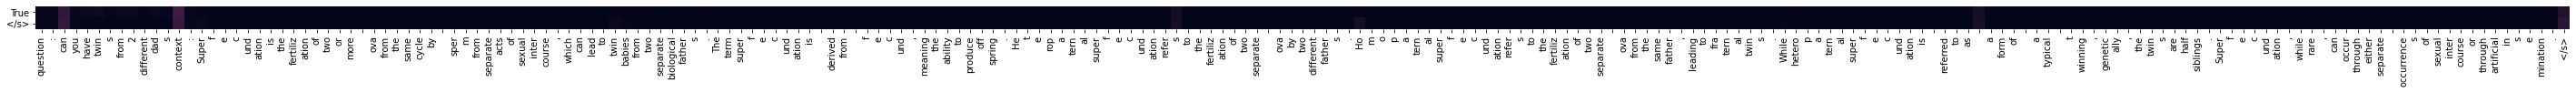

Aggregated heads at layer : 4


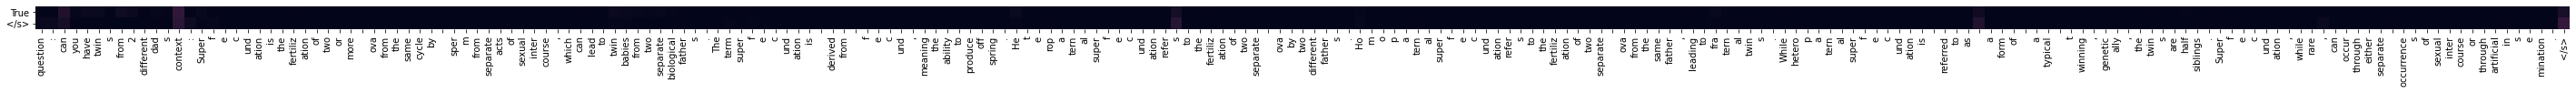

Aggregated heads at layer : 5


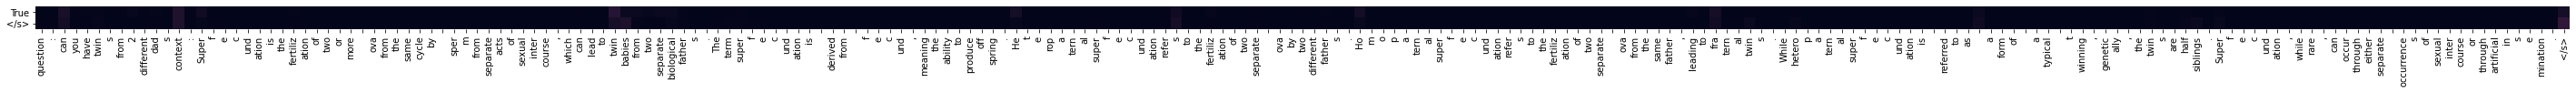

Aggregated heads at layer : 6


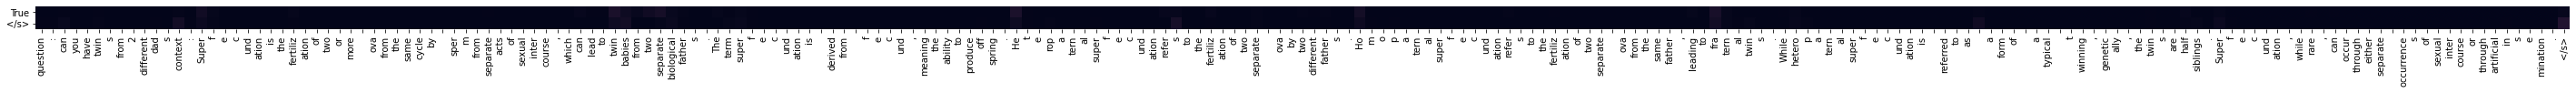

In [ ]:
num_layers = len(outs['cross_attentions'])
for layer in range(num_layers):
    print('Aggregated heads at layer :', layer+1)
    num_heads = outs['cross_attentions'][layer].shape[1]
    fig, axs = plt.subplots(figsize=(50, 50))
    attn = torch.zeros(len(tgt_sent), len(sent))
    for h in range(num_heads):
        attn += outs['cross_attentions'][layer][0, h].data
    draw(attn/num_heads, 
        sent, tgt_sent, ax=axs)
    plt.show()

##### Aggregated per layer

Aggregated layers at head : 1


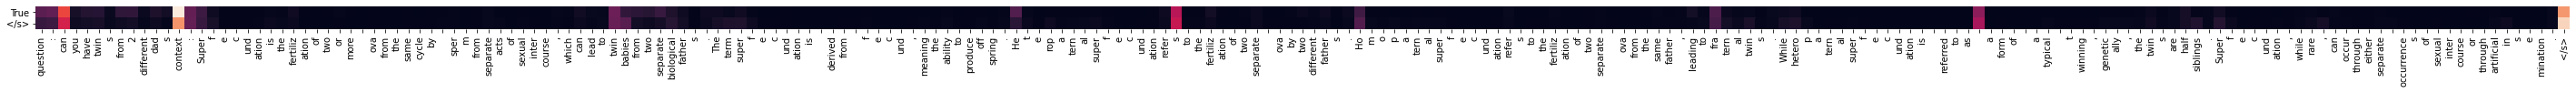

Aggregated layers at head : 2


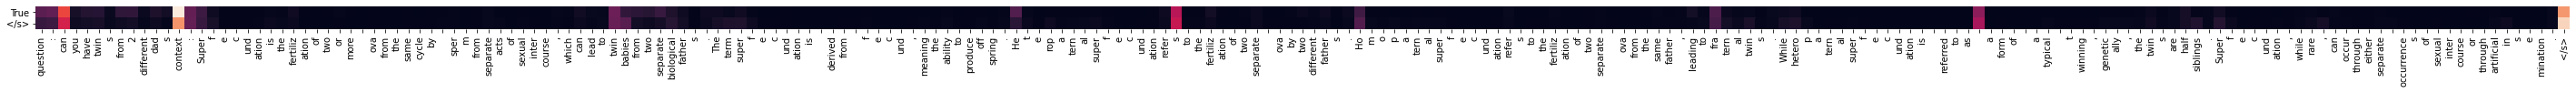

Aggregated layers at head : 3


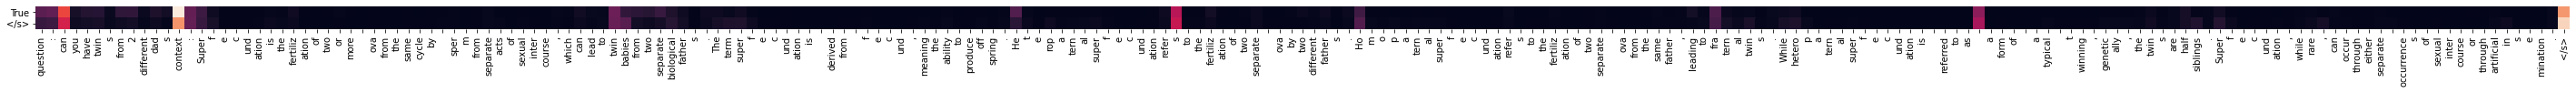

Aggregated layers at head : 4


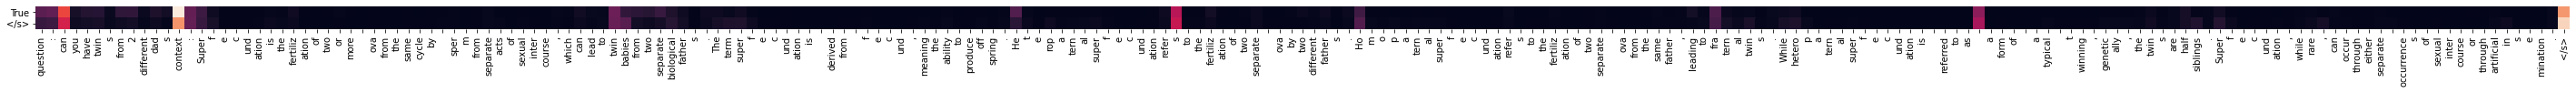

Aggregated layers at head : 5


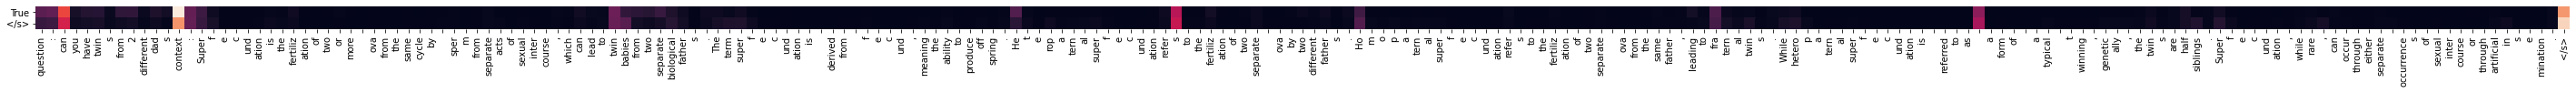

Aggregated layers at head : 6


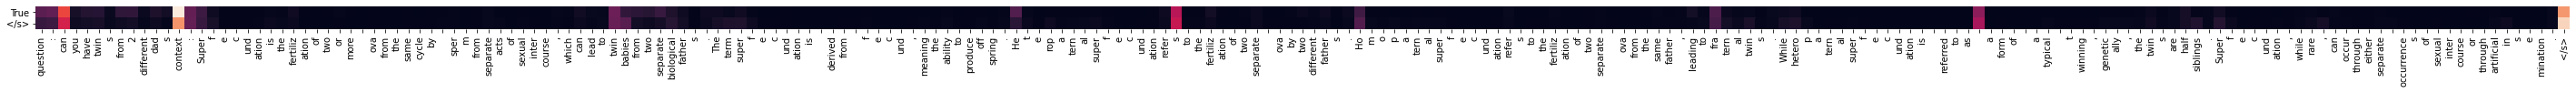

Aggregated layers at head : 7


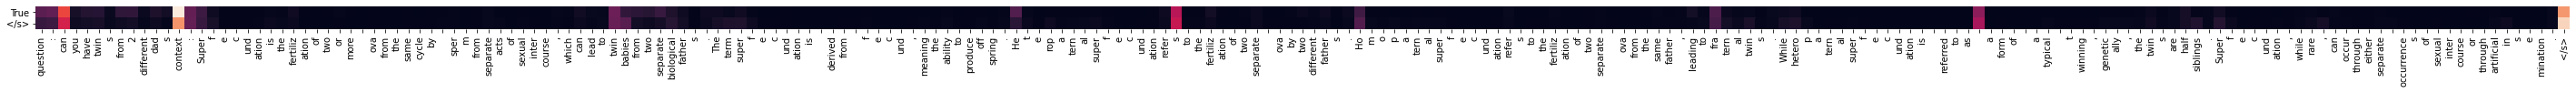

Aggregated layers at head : 8


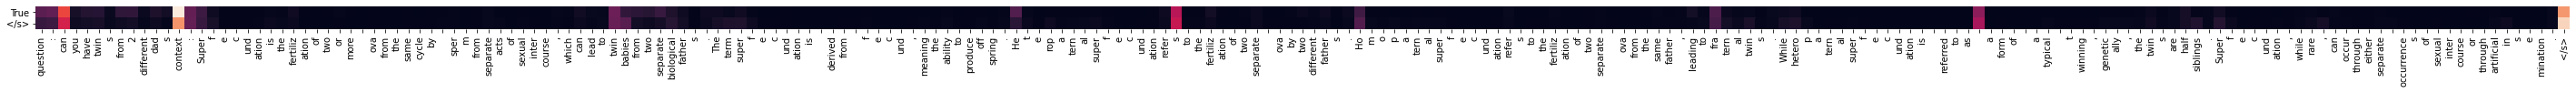

In [ ]:
num_layers = len(outs['cross_attentions'])
num_heads = outs['cross_attentions'][0].shape[1]
attn = [torch.zeros(len(tgt_sent), len(sent))]*num_heads

for layer in range(num_layers):
    num_heads = outs['cross_attentions'][layer].shape[1]
    for h in range(num_heads):
        attn[h] += outs['cross_attentions'][layer][0, h].data
for h in range(num_heads):
    print('Aggregated layers at head :', h+1)
    fig, axs = plt.subplots(figsize=(50, 50))
    draw(attn[layer]/num_layers, 
        sent, tgt_sent, ax=axs)
    plt.show()

### Assess performance with respect to input length

In [ ]:
# Loading the dataset
dataset_bible = load_dataset("bible_para", lang1="en", lang2="fr", split='train')

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


In [ ]:
# Splitting the data into the training set, the valid set and the test set
dataset_train, dataset_valid, dataset_test = buil_bataset(dataset_bible)

Loading cached split indices for dataset at /root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1/cache-d577c107c18c600c.arrow and /root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1/cache-6e180ce0d0142246.arrow
Loading cached split indices for dataset at /root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1/cache-d51bf86392a9c41c.arrow and /root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1/cache-ddd3509bb51a33b4.arrow


In [ ]:
# Loading the model
model = T5ForConditionalGeneration.from_pretrained('t5-small', return_dict=True)
print('Model loaded!')

Model loaded!


In [ ]:
# Getting the input and output encodings according to the tokenizer of t5-small
tokenizer = T5Tokenizer.from_pretrained('t5-small')
input_encodings, output_encodings, batch_input, batch_output = pre_processing(dataset_test, 100)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


In [ ]:
def unpad_sequence(sequence):
    i = -1
    while sequence[i] == 0:
        i += -1
    if i == -1:
        return sequence.view(1, -1)
    else:
        return sequence[:i+1].view(1, -1)

In [ ]:
seq_length = {}

for i in range(100):
    length = unpad_sequence(input_encodings['input_ids'][i]).shape[1]
    seq_length[i] = length

ordered_indices = sorted(list(seq_length.keys()), key=lambda key:seq_length[key], reverse=True)
print('indices of biggest 10 length')
print(ordered_indices[:10])
print('indices of smallest 10 length')
print(ordered_indices[-10:])

indices of biggest 10 length
[32, 45, 71, 83, 42, 0, 16, 81, 28, 20]
indices of smallest 10 length
[17, 54, 60, 13, 64, 73, 6, 67, 57, 85]


In [ ]:
i_min = ordered_indices[-1]
i_max = ordered_indices[0]

small_len_input = unpad_sequence(input_encodings['input_ids'][i_min])
big_len_input = unpad_sequence(input_encodings['input_ids'][i_max])

small_len_output = unpad_sequence(output_encodings['input_ids'][i_min])
big_len_output = unpad_sequence(output_encodings['input_ids'][i_max])

In [ ]:
# outs = model(input_ids=input_encodings['input_ids'], decoder_input_ids=output_encodings['input_ids'], output_attentions=True)
outs = model(input_ids=small_len_input, labels=small_len_output, output_attentions=True)
sent = get_sent_from_ids(input_encodings, i_min)
tgt_sent = get_sent_from_ids(output_encodings, i_min)

In [ ]:
print('English sentence')
print(' '.join(sent[:seq_length[i_min]]))
print('French sentence')
try:
    pad_ind_tgt = tgt_sent.index('<pad>')
except:
    pad_ind_tgt = None
print(' '.join(tgt_sent[:pad_ind_tgt]))

English sentence
translate English to French : E ber , Pe leg , Re u , </s>
French sentence
H é ber , P é leg , Re h u , </s>


In [ ]:
sent = sent[:seq_length[i_min]]
tgt_sent = tgt_sent[:pad_ind_tgt]

In [ ]:
print('Here, input length is equal to', seq_length[i_min])

Here, input length is equal to 15


Cross-Layer number : 1


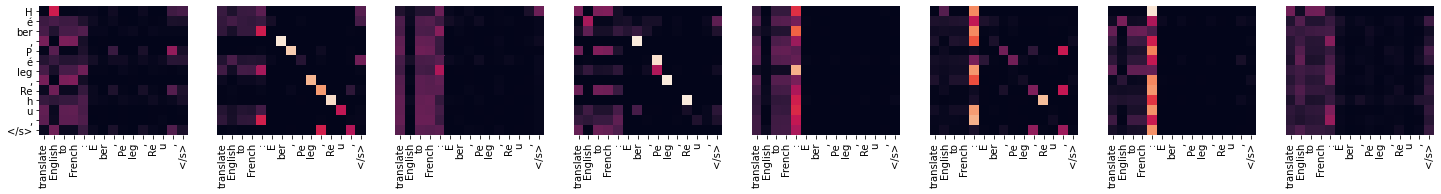

Cross-Layer number : 2


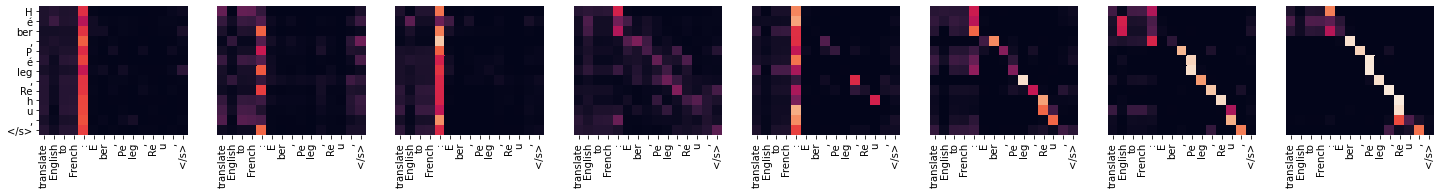

Cross-Layer number : 3


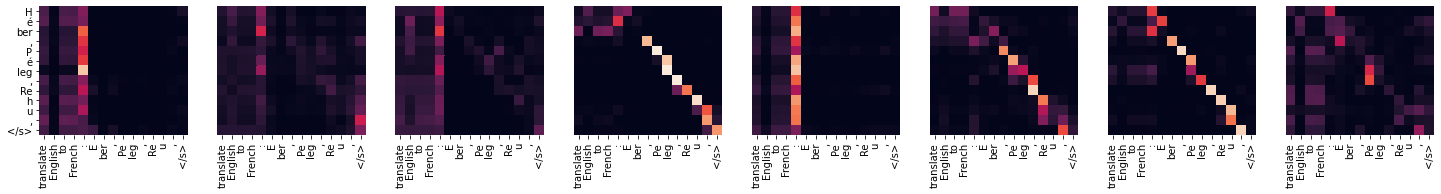

Cross-Layer number : 4


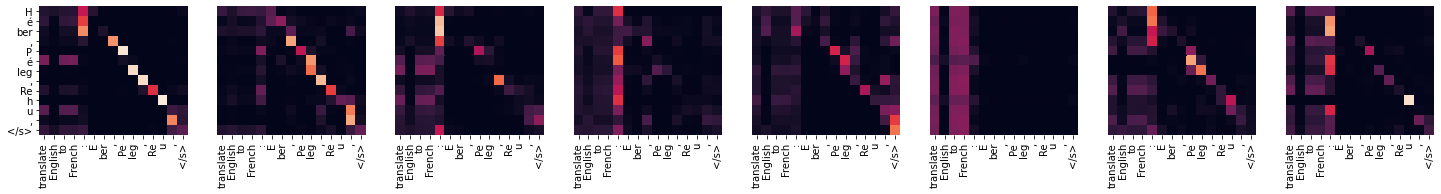

Cross-Layer number : 5


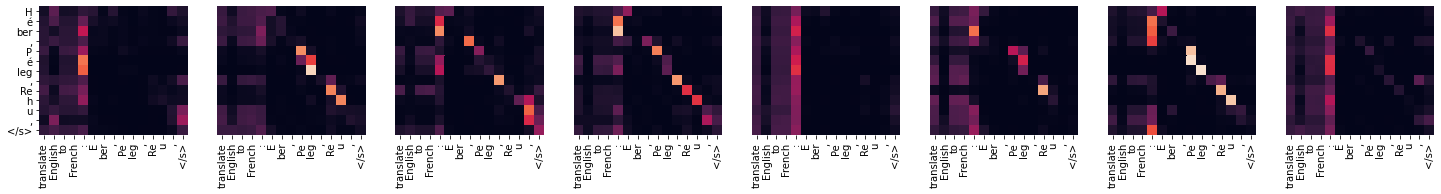

Cross-Layer number : 6


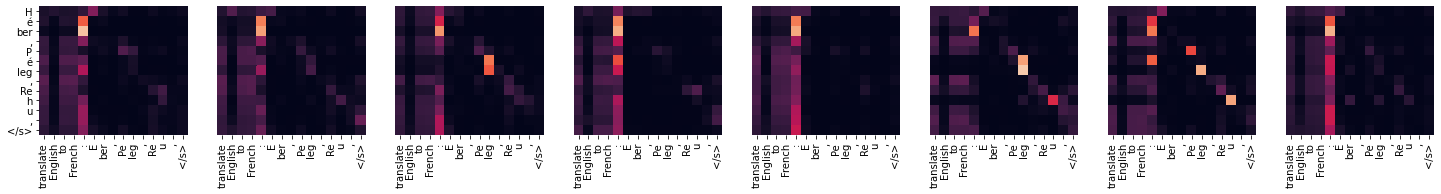

In [ ]:
num_layers = len(outs['cross_attentions'])
for layer in range(num_layers):
    print('Cross-Layer number :', layer+1)
    num_heads = outs['cross_attentions'][layer].shape[1]
    fig, axs = plt.subplots(1,num_heads, figsize=(25, 15))
    for h in range(num_heads):
        draw(outs['cross_attentions'][layer][0, h].data, 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()

In [ ]:
# outs = model(input_ids=input_encodings['input_ids'], decoder_input_ids=output_encodings['input_ids'], output_attentions=True)
outs = model(input_ids=big_len_input, labels=big_len_output, output_attentions=True)
sent = get_sent_from_ids(input_encodings, i_max)
tgt_sent = get_sent_from_ids(output_encodings, i_max)

In [ ]:
print('English sentence')
print(' '.join(sent[:seq_length[i_max]]))
print('French sentence')
try:
    pad_ind_tgt = tgt_sent.index('<pad>')
except:
    pad_ind_tgt = None
print(' '.join(tgt_sent[:pad_ind_tgt]))

English sentence
translate English to French : The n As a took all the silver and the gold that were left in the treasure s of the house of Ya h we h , and the treasure s of the  king ' s house , and delivered them into the hand of his servant s ; and  king As a sent them to Ben Had a d , the son of Tab rim mon , the son of He zi on ,  king of Syria , who lived at Dam a s cu s , saying , </s>
French sentence
As a  pri t tout  l <unk> argent  e t tout  l <unk> or qui  étaient rest és dans les trésor s de la maison de  l <unk> É tern e l  e t les trésor s de la maison du  r o i ,  e t  il les mit entre les main s de ses servi teur s qu <unk> il  en voy a vers Ben Had a d , fil s de Tha bri mm on , fil s de He z jon ,  r o i de Sy rie , qui habit a it  à Dam a s . Le  r o i As a lui fit dire : </s>


In [ ]:
sent = sent[:seq_length[i_max]]
tgt_sent = tgt_sent[:pad_ind_tgt]

In [ ]:
print('Here, input length is equal to', seq_length[i_max])

Here, input length is equal to 99


Cross-Layer number : 1


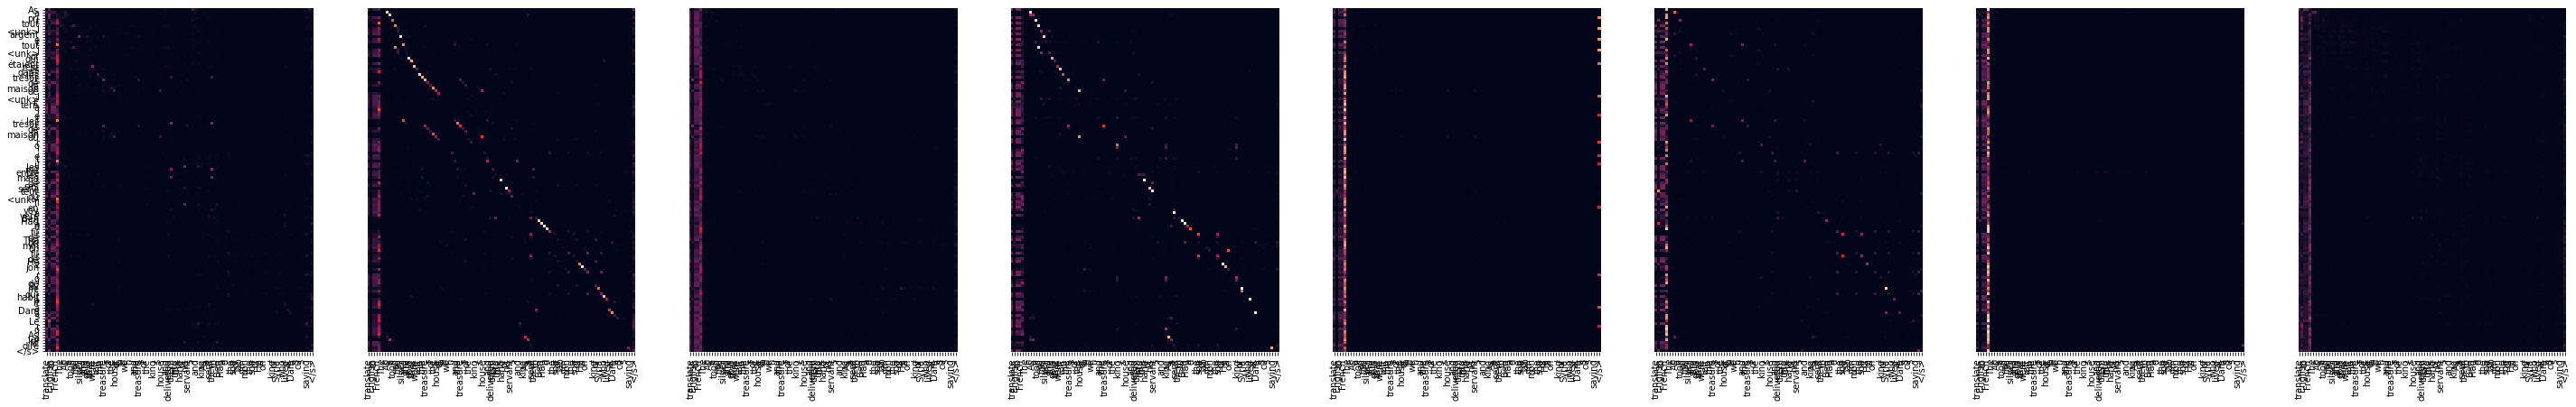

Cross-Layer number : 2


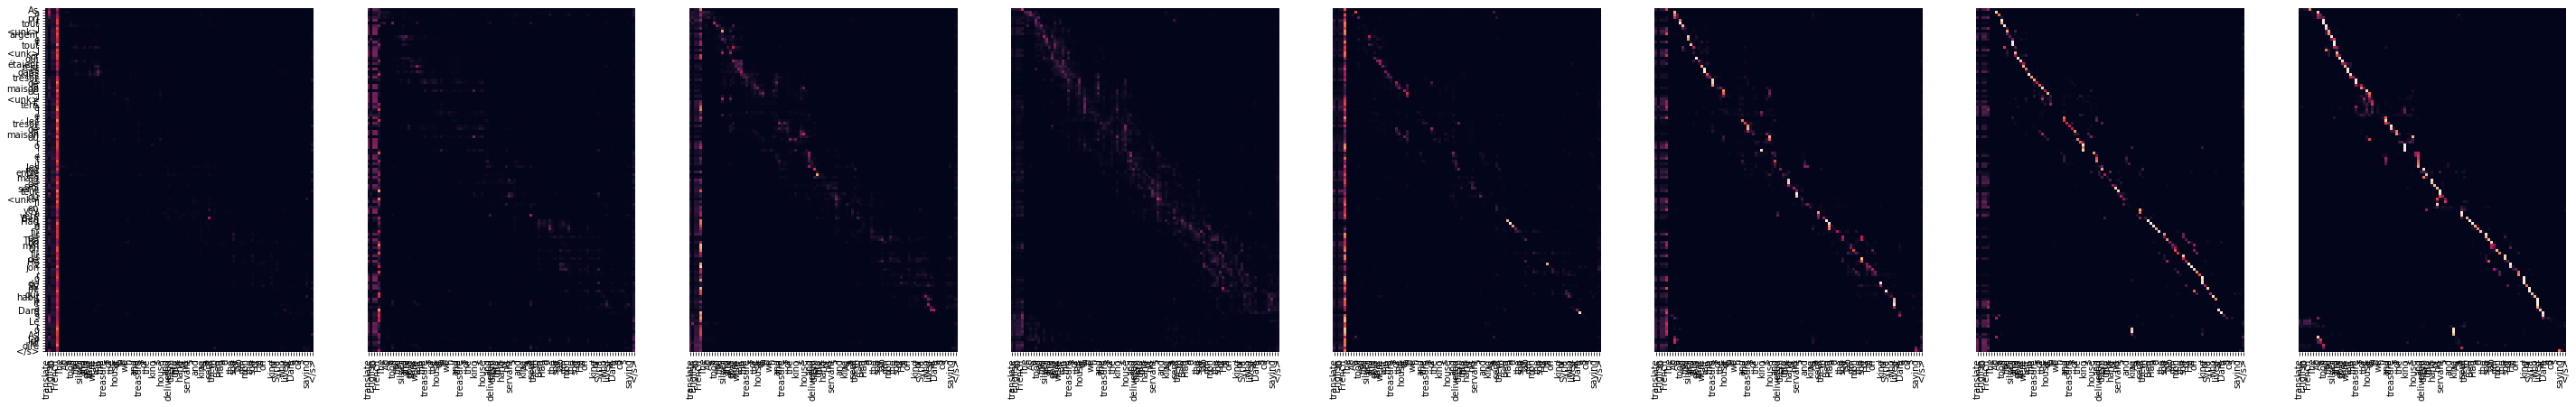

Cross-Layer number : 3


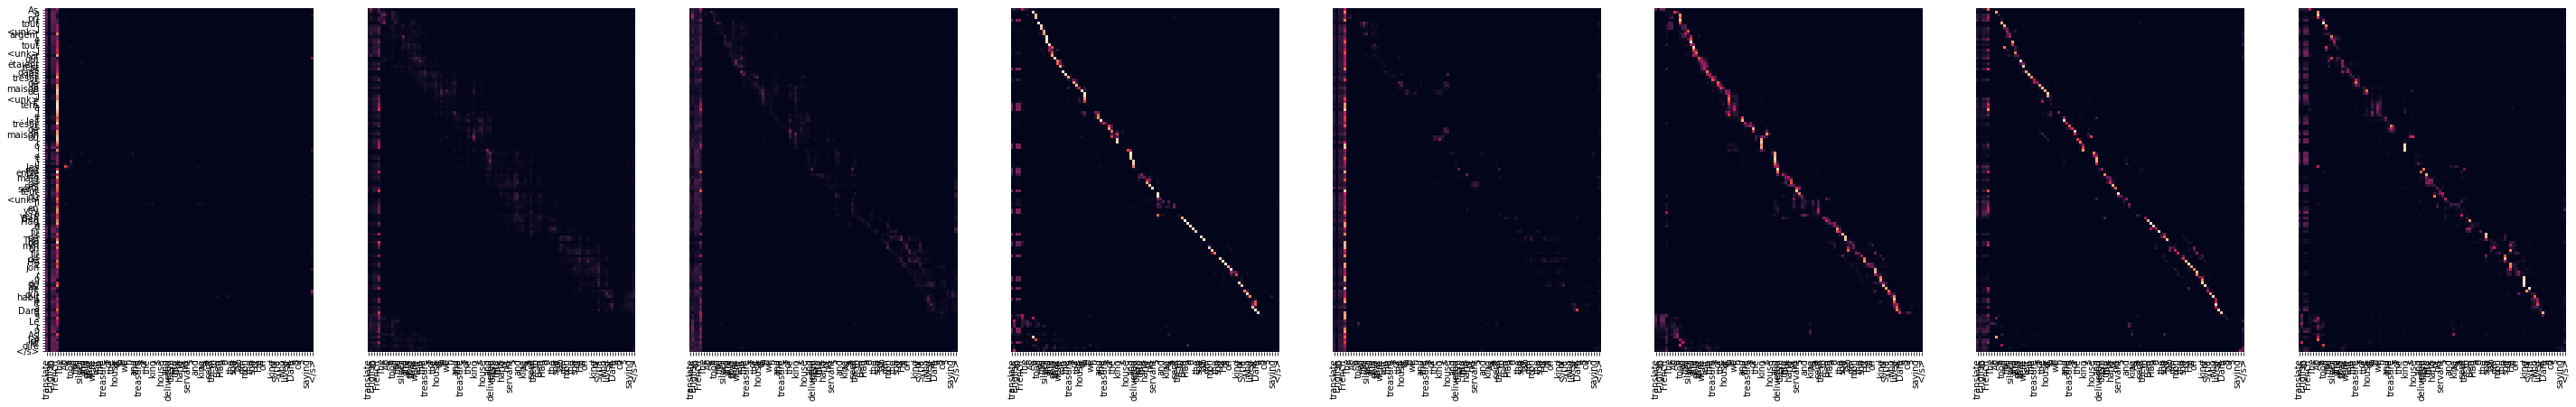

Cross-Layer number : 4


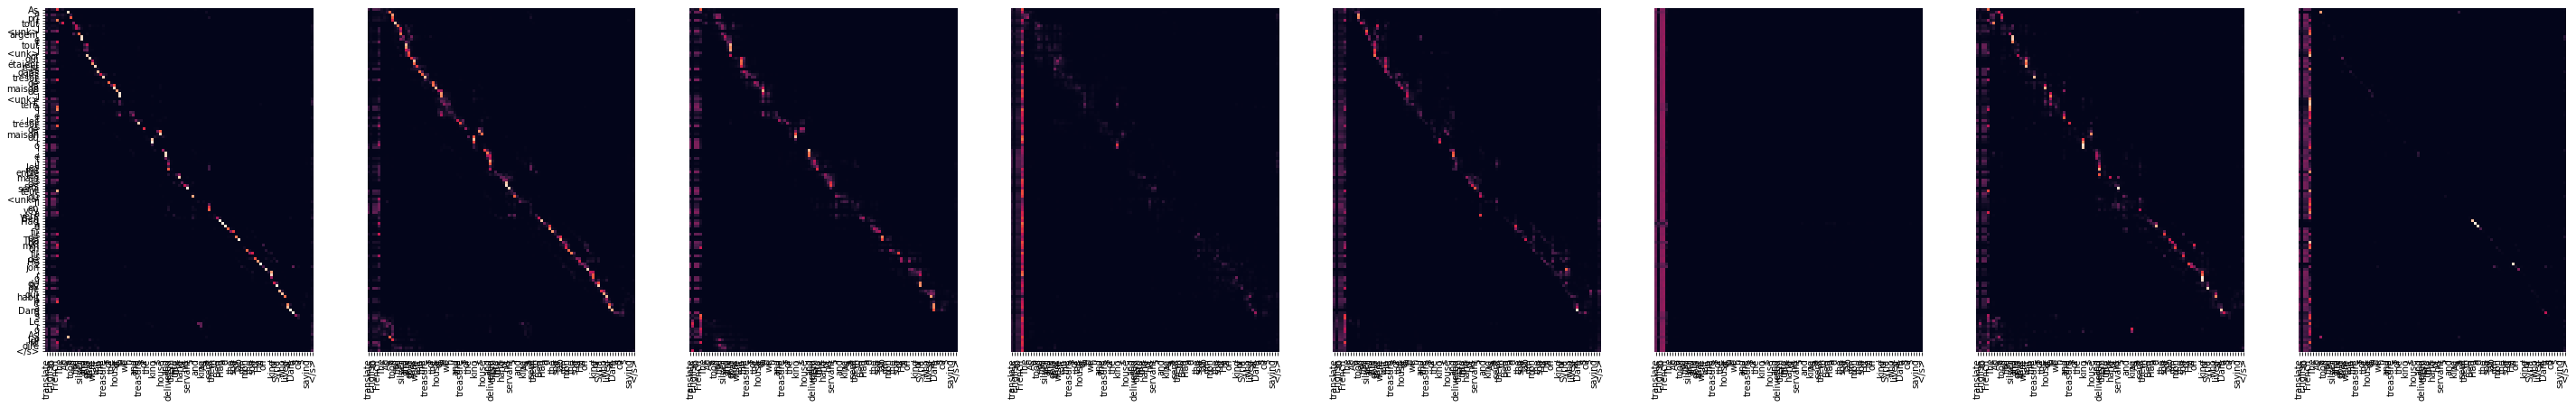

Cross-Layer number : 5


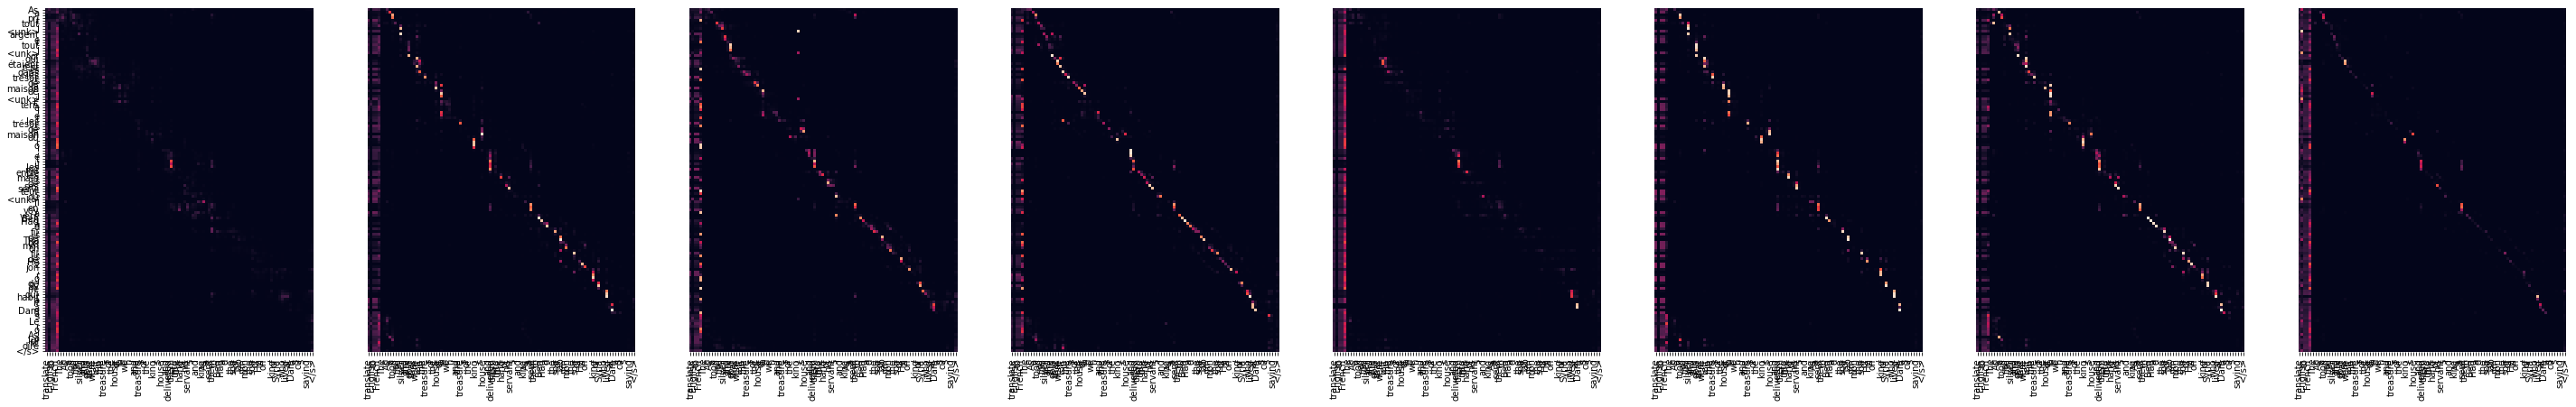

Cross-Layer number : 6


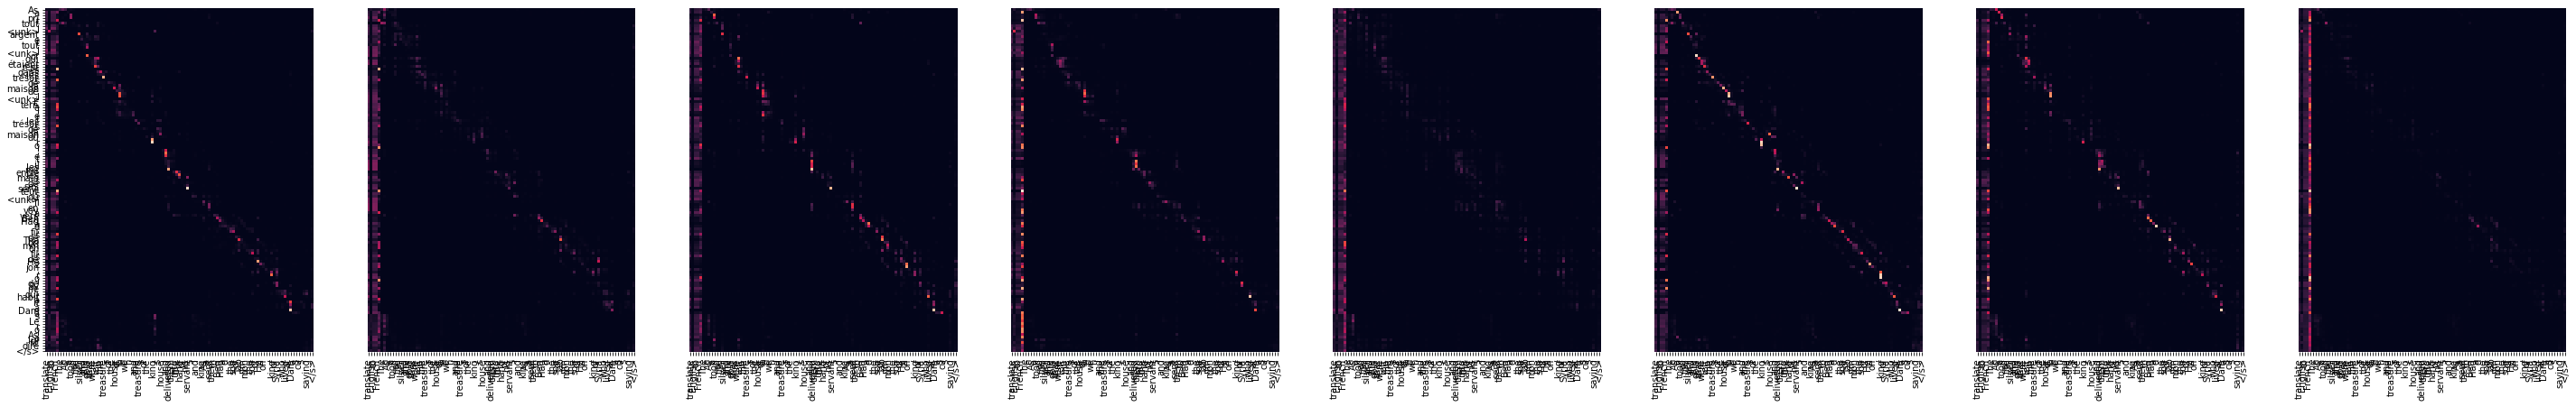

In [ ]:
num_layers = len(outs['cross_attentions'])
for layer in range(num_layers):
    print('Cross-Layer number :', layer+1)
    num_heads = outs['cross_attentions'][layer].shape[1]
    fig, axs = plt.subplots(1,num_heads, figsize=(50, 15))
    for h in range(num_heads):
        draw(outs['cross_attentions'][layer][0, h].data, 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()

### Short report on attention visualization


**First, for the attention matrices per head/layer :**

for some matrices, it is easy to deduce what the weights represent : for translation, it usually maps a word to its translation, for summarization, usually puts most of the weight on the most important words of the paragraph, and for question answering, it puts the weights on the most relevant words for the answer.

However, we still observe full-black matrices, which indicates that not all matrices represent the natural "attention" we think of. But it seems like each matrix will be specialized in a certain part of the attention.

**Now, for the aggregation :**

It seems like aggregating layers per head outputs way higher weights than aggregating heads per layer. However, aggregating layers will output too much noise (in terms of noisy weights, which are undesirable). On the other hand, aggregating heads will output a softer attention matrix, which puts weights on the most relevant words.

**Assessing the performance according to input length :**

It seems like the model is robust to input length. We took one short input, and one very long, and outputed their attention matrices. Turns out, both are mostly sparse, with weights on the right places. Which allows us to think that attention models are robust to input length, which on a semantic point of view, is more or less desirable.




## Deliverable 2.2:  Implement one of these methods for Attention aggregation (Condifence score or LRP) 

In [ ]:
def draw_confidence_map(matrix,ax,title):
  num_layers, num_heads = matrix.shape
  seaborn.heatmap(matrix, 
                    xticklabels=list(range(num_heads)), square=True, yticklabels= list(range(num_layers)), cmap='Blues', 
                    cbar=True, ax=ax)
  
  ax.set_title(title)
  ax.set_ylabel('Layers')
  ax.set_xlabel('Heads')

In [ ]:
def confidence_map(model,processing_fun,dataset,n,type_attn,display=False):
  
  input_encodings, output_encodings, _, _  = processing_fun(dataset, n)

  attn_maps = []

  #Treat each sentence indivudually because otherwise we will have issue to determine the end of the sentence because of the padding
  for i in range(n):
      sent = torch.masked_select(input_encodings['input_ids'][i], input_encodings['attention_mask'][i].bool())
      tgt_sent = torch.masked_select(output_encodings['input_ids'][i], output_encodings['attention_mask'][i].bool())
      out_sent = model(input_ids=sent.unsqueeze(0), labels=tgt_sent.unsqueeze(0), output_attentions=True)
      attn_sent = out_sent[type_attn]
      attn_maps.append(attn_sent)

  num_layers = len(attn_maps[0])
  num_heads = attn_maps[0][0].size(1)
  max_list = [[[] for _ in range(num_heads)] for _ in range(num_layers)]

  for i in range(n):
    for layer in range(num_layers):
      for head in range(num_heads):
        max_weight = torch.max(attn_maps[i][layer][0,head],dim=0).values[:-1].float() ## we don't take the last special token </s>
        max_list[layer][head].append(max_weight) 

  confidence_map_attn = np.zeros((num_layers,num_heads))
  for layer in range(num_layers):
      for head in range(num_heads):
        full_max_weight = torch.cat(max_list[layer][head])
        confidence_map_attn[layer,head] = torch.mean(full_max_weight).item()


  confidence_map_attn = (confidence_map_attn - np.min(confidence_map_attn))/np.max(confidence_map_attn)

  if display:
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    draw_confidence_map(confidence_map_attn,ax,'Mean max attention weight')
    plt.show()
  else:
    return confidence_map_attn

### Translation

In [ ]:
# Loading the dataset
dataset_bible = load_dataset("bible_para", lang1="en", lang2="fr", split='train')
# Splitting the data into the training set, the valid set and the test set
dataset_train, dataset_valid, dataset_test = buil_bataset(dataset_bible)

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


In [ ]:
# Loading the model
model = T5ForConditionalGeneration.from_pretrained('t5-small', return_dict=True)
print('Model loaded!')
# Getting the input and output encodings according to the tokenizer of t5-small
tokenizer = T5Tokenizer.from_pretrained('t5-small')

Model loaded!


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


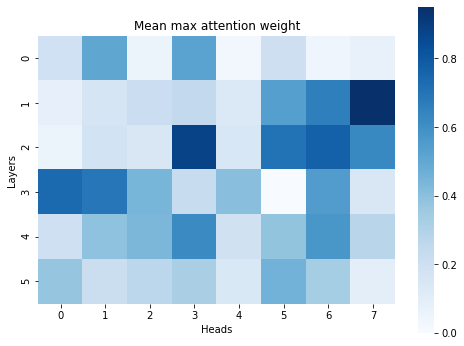

In [ ]:
confidence_map(model,pre_processing, dataset_test,10,'cross_attentions',display=True)

### Summarization

In [ ]:
dataset_cnn_test = load_dataset("cnn_dailymail", '3.0.0', split='test')

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0a01b1abede4f646130574f203de57a293ded8a7a11e3406a539453afdfeb2c0)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


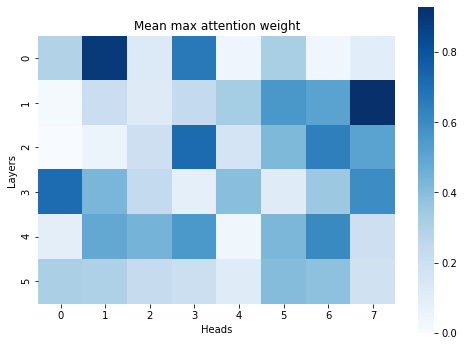

In [ ]:
confidence_map(model,pre_processing_summarize, dataset_cnn_test,10,'cross_attentions',display=True)

### Question Answering

In [ ]:
# Loading the dataset
dataset_bool_train, dataset_bool_valid, dataset_bool_test = build_bataset_bool("boolq")

Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Loading cached split indices for dataset at /root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534/cache-28dd43d82ece444a.arrow and /root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534/cache-dfd0bbffcdd94d36.arrow


In [ ]:
# Loading the model
from transformers import AutoModelForSeq2SeqLM
model_qa = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-small-finetuned-boolq")
print('Model loaded!')

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Model loaded!


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:175: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


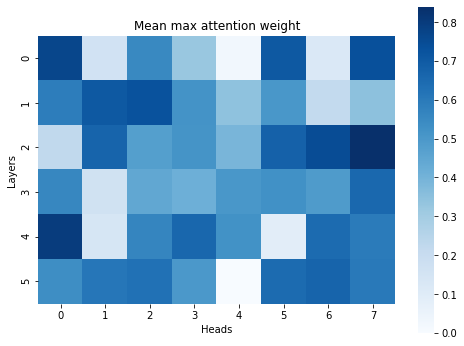

In [ ]:
confidence_map(model_qa, pre_processing_qa, dataset_bool_test,100,'cross_attentions',display=True) 

### Comparison

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:175: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


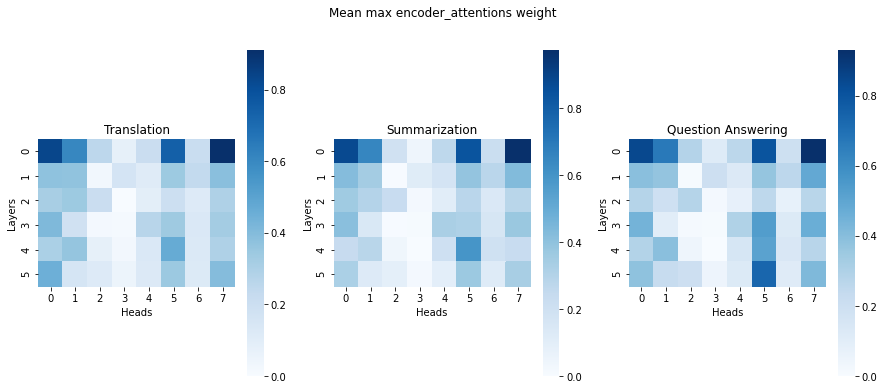




--------------------


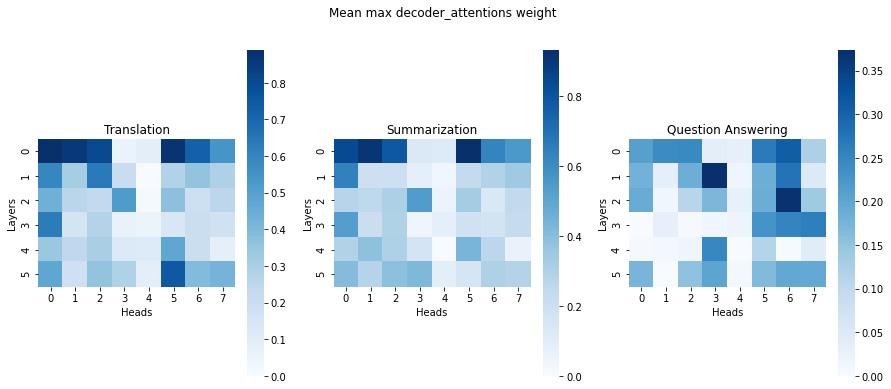




--------------------


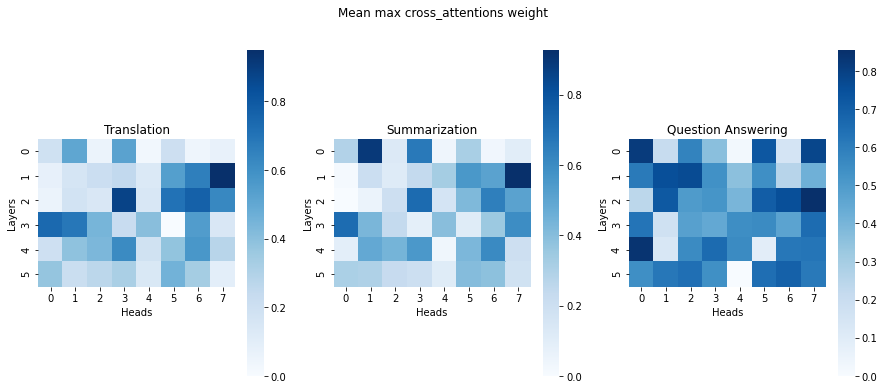




--------------------


In [ ]:
type_attn = ['encoder_attentions','decoder_attentions', 'cross_attentions']
pre_processing_list = [pre_processing,pre_processing_summarize,pre_processing_qa]
dataset_list = [dataset_test,dataset_cnn_test,dataset_bool_test]
model_list = [model,model,model_qa]
task = ['Translation','Summarization','Question Answering']
n_tasks = len(pre_processing_list)
for attn in type_attn:
  fig, axs = plt.subplots(1, n_tasks, figsize = (15,6))
  for i in range(n_tasks):
    conf_matrix = confidence_map(model_list[i],pre_processing_list[i],dataset_list[i],10,attn)
    draw_confidence_map(conf_matrix,axs[i],task[i])
  fig.suptitle(f'Mean max {attn} weight')
  plt.show()
  print('\n\n')
  print('-'*20)

**Analysis of the confidence map**


In this part we computed the confidence map associated with different attention maps. We compared the confidence map for the following 3 tasks: Translation, Summarization, Question Answering. The T5 model contains 3 types of attention layer: encoder attention, decoder attention and cross attention (which combine the encoder and decoder features). Hence, we decided to plot the different confidence attention map associated. 

First, for the encoder attention. As we can see, for the 3 tasks we have the same trend. The first layer is the most important one because it contains all the high value. It can be explained by the fact that it is at the first step that we make the greatest transformation and we extract most of the information. Since the confidence map is similar for each task we can think that the encoder part is the same and do not apply specific task.

Second, the decoder attention. Here we can already see some differences between the tasks. For translation and summarization, the first layer is still the most active one with very high value. For the question answering, it is in the second and third layers that we see the highest activity and only on a few heads. Globally, we see that for translation and summarization the confidence maps have very few attention maps that are useless because the confidence scores are not close to 0. However, for the question answering task, the confidence map is very sparse and only a few attention layers seem to give the final answer.

Finally, the cross attention which combines encoder and decoder outputs. Here the map is very different. The highest confidence scores for translation and summarization are in the middle layers. This cross attention seems to be complementary with the decoder attention. For the question answering task, the confidence map has high confidence for each layer and head. It means that the model is very confident from the beginning to the end.
